# D208 Predictive Modeling: Logistic Regression
**Desiree McElroy**\
Using the medical dataset.

In [1]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

import sys
print(f'Python version: {sys.version}')
import IPython
print(f'IPython jupyter kernel version: {IPython.__version__}')

Python version: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
IPython jupyter kernel version: 8.12.3


# Part I: Research Question

## A1. Research Question

My research question is, what factors if any are the cause of readmissions occurring? What features are correlated to a patient being readmitted to a hospital within 30 days?





## A2.  Goals of the Data Analysis.
The goals of this data analysis are essentially to uncover what factors influence whether a patient is readmitted within 30 days of release. By examining the data, I aim to uncover key relationships between patients who are readmitted and those who are not. This analysis could help identify which demographics/characteristics are more prone to readmission, as well as identify geographical areas and hospital stay events that may impact readmission. The insights gathered here could provide valuable understanding for improving patient care and reducing readmission rates.

# Part II: Method Justification

## B1.  Four Assumptions of a Logistic Regression Model.
- The target variable should be binary or ordinal, in this case binary.
- Each observation (row) should be independent of each other, avoiding any repeat entries or matched data.
- No Multicollinearity, meaning the features in the dataset should be independent of one another or have very little multicollinearity. Otherwise, the relationship between the dependent and independent variables will be difficult to identify.
- No extreme outliers. Logistic regression works by modeling a relationship through probabilities scaled between 0 and 1. Anamalous values negatively affect the variable coefficients causing the model to train poorly.

## B2.  Benefits of using Python
Python is my choice of programming language due to it's ease of use and robust use in data science. Python has many versatile libraries including numpy (numerical python operations), pandas (used for manipulation of dataframes), scipy (used for statistical operations), and matplotlib and seaborn (strong versatile visualization packages).

During the wrangling phase, Python's pandas library proves to be incredibly useful for the manipulation of dataframes, including cleaning, transforming and creating new features. It also have many useful functions needed to help prepare dataframes for modeling such as functions to fill nulls or to change data types. Numpy is also an analyst favorite with it's powerful performance with numerical operations on arrays.

Data exploration and statistics phases also greatly benefit from the various functions within Python. The visual libraries including matplotlib and seaborn have versatile graphs that provide easy access to quick insights. Distribution charts, scatterplots and heatmaps are a few of my most used functions that help assess the distribution and relative relation to features within the dataset.

In summary, python's versatile libraries, ease of use and large community make it a strong tool for data science.

## B3. Why logistic regression is an appropriate technique.
- Logistic regression is quite similar to linear regression, but instead uses probability to predict which class each observation belongs to. In a dataset with a binary target variable, the algorithm essentially "takes input as independent variables and produces a probability value between 0 and 1" (*Geeks for Geeks, Understanding Logistic Regression*). The default threshold for logistic regression is set to 0.5. Each observation is given a probability score between 0 and 1, if an input is >=0.5, then the input is considered positive, or 1.
- In contrast to linear regression, logistic regression employs a logit function (Sigmoid) shaped like an **S** on a graph where the value range is (0,1). 
- This technique is more than appropriate for our current business problem as we are aiming to predict whether a patient was readmitted (1) or not (0). Using feature variables, the algorithm using the logistic regression to predict a likelihood of that patient (the observation) being readmitted. If one patient's features return a likelihood of 0.83, they are considered to be predicted positive, whereas a likelihood of 0.45 would be considered predicted negative. This threshold can be adjusted depending on the model's performance and the business needs (e.g. to favor recall or precision). For this project, the threshold will remain at the default 0.5.

# Part III: Data Preparation

## C1. Data Cleaning Goals

In line with my previous data cleaning approach from D206 and linear regression, my plan is to systematically assess and clean the dataframe as needed. I will evaluate the data types of each column and convert them to appropriate types such as integer, float, or boolean. Next, I will identify and address any duplicates or missing values by either removing, separating, or imputing them. For this dataset, duplicates and null values are not present. Finally, I will conduct a thorough review of the data to ensure its accuracy, which may involve correcting spelling errors, fixing typos, and standardizing text formatting for readability.

To clean the dataset, I will begin by ensuring all zip codes are at least five digits by padding with zeros where necessary. The timezone column will be standardized to align with the nine main time zones and converted to a categorical data type. Columns such as readmission, soft_drink, and other health related variables with yes/no or (1,0) responses will be converted to boolean data types. Values in columns like vitd_levels, daily_charges, and additional_charges will be rounded to two decimal places. Columns such as population, children, and income will be corrected from float to integer types.

Columns including marital, gender, and other service related fields will be designated as categorical data types. As columns like income fall within reasonable bounds, no further change will be applied.

In [2]:
# bring in dataframe
df = pd.read_csv('medical_raw_df.csv', index_col=[0])
# lowercase columns
df.columns = map(str.lower, df.columns)

# verify no nulls
assert df.isnull().sum().sum() == 0
# verify no duplicates
assert df.duplicated().sum() == 0

    
# change timezone column entries before changing data type
tz_dict = {
    "America/Puerto_Rico" : "US - Puerto Rico",
    "America/New_York": "US - Eastern",
    "America/Detroit" : "US - Eastern",
    "America/Indiana/Indianapolis" : "US - Eastern",
    "America/Indiana/Vevay" : "US - Eastern",
    "America/Indiana/Vincennes" : "US - Eastern",
    "America/Kentucky/Louisville" : "US - Eastern",
    "America/Toronto" : "US - Eastern",
    "America/Indiana/Marengo" : "US - Eastern",
    "America/Indiana/Winamac" : "US - Eastern",
    "America/Chicago" : "US - Central", 
    "America/Menominee" : "US - Central",
    "America/Indiana/Knox" : "US - Central",
    "America/Indiana/Tell_City" : "US - Central",
    "America/North_Dakota/Beulah" : "US - Central",
    "America/North_Dakota/New_Salem" : "US - Central",
    "America/Denver" : "US - Mountain",
    "America/Boise" : "US - Mountain",
    "America/Phoenix" : "US - Arizona",
    "America/Los_Angeles" : "US - Pacific",
    "America/Nome" : "US - Alaskan",
    "America/Anchorage" : "US - Alaskan",
    "America/Sitka" : "US - Alaskan",
    "America/Yakutat" : "US - Alaskan",
    "America/Adak" : "US - Aleutian",
    "Pacific/Honolulu" : 'US - Hawaiian'
    }
df.timezone.replace(tz_dict, inplace=True)

# convert zip column to str, then fill 0s in entries
df.zip = df.zip.astype('str').str.zfill(5)

# changing datatypes
# change columns to boolean data type
to_bool = ['readmis',
           'soft_drink',
           'highblood',
           'stroke',
           'overweight',
           'arthritis',
           'diabetes',
           'hyperlipidemia',
           'backpain',
           'anxiety',
           'allergic_rhinitis',
           'reflux_esophagitis',
           'asthma']

for col in to_bool:
    df[col] = df[col].replace({'Yes':1, 'No':0}).astype(bool)


# round entries in columns to only have two decimal places
round_num = ['vitd_levels',
             'totalcharge',
             'additional_charges']
for col in round_num:
    df[col] = round(df[col], 2)

# change columns to integer data type
to_int = ['population',
          'children',
          'age',
          'income',
          'initial_days']
for col in to_int:
    df[col] = df[col].astype('int32')

# change columns to categorical data type
to_cat = ['marital',
          'gender',
          'initial_admin',
          'services',
          'item1',
          'item2',
          'item3',
          'item4',
          'item5', 
          'item6',
          'item7',
          'item8',
          'timezone',
          'state',
          'complication_risk']
for col in to_cat:
    df[col] = df[col].astype('category')
      
# make columns more readable  
columns = {'caseorder':'case_order',
          'uid':'unique_id',
          'readmis':'readmission',
          'vitd_supp':'vitd_supplement',
          'highblood':'high_blood',
          'services':'services_received',
          'totalcharge':'daily_charges',
          'initial_days':'hospital_stay_days'}


df[['item1','item2', 'item3', 'item4']] = df[['item1','item2', 'item3', 'item4']].astype('int32')
df[['item5','item6', 'item7', 'item8']] = df[['item5','item6', 'item7', 'item8']].astype('int32')


df.rename(columns=columns, inplace=True)
df = df.reset_index()

In [3]:
# separate exploratory variables into type for ease of exploring

# ordinal variables
ordinal_vars = ['age',
             'income',
             'vitd_levels',
             'daily_charges',
             'additional_charges',
             'population',
             'children',
             'doc_visits',
             'full_meals_eaten',
             'vitd_levels',
             'vitd_supplement',
             'hospital_stay_days']

# categorical variables
cat_vars = ['gender', 
            'marital',
            'area',
            'timezone', 
            'initial_admin',
            'complication_risk',
            'services_received']
             # 'item1', # exclude,not be used in final model
             # 'item2',
             # 'item3',
             # 'item4',
             # 'item5',
             # 'item6',
             # 'item7',
             # 'item8']


# List of boolean health-related variables
boolean_vars = ['high_blood', 
                'stroke',  
                'overweight', 
                'arthritis', 
                'diabetes', 
                'hyperlipidemia', 
                'backpain', 
                'anxiety', 
                'allergic_rhinitis', 
                'reflux_esophagitis', 
                'asthma',
                'soft_drink']

## C2.  Summary Statistics

***Target Variable: Readmissions***

In [4]:
df.readmission.value_counts(normalize=True)

False    0.6331
True     0.3669
Name: readmission, dtype: float64

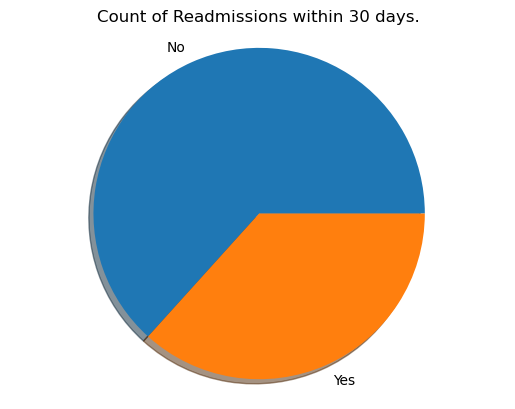

In [5]:
plt.pie(df.readmission.value_counts(normalize=True),
        labels = ['No', 'Yes'], shadow=True)
plt.axis('equal')
plt.title('Count of Readmissions within 30 days.')
plt.show()

### Numerical Variables

In [6]:
# statistics for numerical variables
numerical_summ = df[ordinal_vars].describe()
print('Summary statistics for numerical feature columns:\n')
numerical_summ.T

Summary statistics for numerical feature columns:



,count,mean,std,min,25%,50%,75%,max
age,10000.0,53.511700,20.638538,18.00,36.0000,53.00,71.00,89.00
income,10000.0,40490.002100,28521.152883,154.00,19598.2500,33768.00,54295.75,207249.00
vitd_levels,10000.0,17.964272,2.017259,9.81,16.6275,17.95,19.35,26.39
daily_charges,10000.0,5312.172758,2180.393815,1938.31,3179.3750,5213.95,7459.70,9180.73
additional_charges,10000.0,12934.528592,6542.601554,3125.70,7986.4850,11573.98,15626.49,30566.07
population,10000.0,9965.253800,14824.758614,0.00,694.7500,2769.00,13945.00,122814.00
children,10000.0,2.097200,2.163659,0.00,0.0000,1.00,3.00,10.00
doc_visits,10000.0,5.012200,1.045734,1.00,4.0000,5.00,6.00,9.00
full_meals_eaten,10000.0,1.001400,1.008117,0.00,0.0000,1.00,2.00,7.00
vitd_levels,10000.0,17.964272,2.017259,9.81,16.6275,17.95,19.35,26.39


### Categorical Variables

In [7]:
# distribution of categorical variables
print("\nDistribution for categorical variables:")
for var in cat_vars:
    print(f'\n{var}:')
    print(df[var].value_counts(normalize=True) * 100)  # display percentages


Distribution for categorical variables:

gender:
Female       50.18
Male         47.68
Nonbinary     2.14
Name: gender, dtype: float64

marital:
Widowed          20.45
Married          20.23
Separated        19.87
Never Married    19.84
Divorced         19.61
Name: marital, dtype: float64

area:
Rural       33.69
Suburban    33.28
Urban       33.03
Name: area, dtype: float64

timezone:
US - Eastern        43.26
US - Central        37.92
US - Pacific         9.37
US - Mountain        6.98
US - Arizona         1.00
US - Alaskan         0.69
US - Puerto Rico     0.43
US - Hawaiian        0.34
US - Aleutian        0.01
Name: timezone, dtype: float64

initial_admin:
Emergency Admission      50.60
Elective Admission       25.04
Observation Admission    24.36
Name: initial_admin, dtype: float64

complication_risk:
Medium    45.17
High      33.58
Low       21.25
Name: complication_risk, dtype: float64

services_received:
Blood Work     52.65
Intravenous    31.30
CT Scan        12.25
MRI      

### Boolean Variables

In [8]:
# Frequency distribution for boolean variables
print('Frequency distribution for boolean variables:')
for col in boolean_vars:
    print(f'\n{col}:')
    print(df[col].value_counts(normalize=True) * 100)  # display percentages

Frequency distribution for boolean variables:

high_blood:
False    59.1
True     40.9
Name: high_blood, dtype: float64

stroke:
False    80.07
True     19.93
Name: stroke, dtype: float64

overweight:
True     70.94
False    29.06
Name: overweight, dtype: float64

arthritis:
False    64.26
True     35.74
Name: arthritis, dtype: float64

diabetes:
False    72.62
True     27.38
Name: diabetes, dtype: float64

hyperlipidemia:
False    66.28
True     33.72
Name: hyperlipidemia, dtype: float64

backpain:
False    58.86
True     41.14
Name: backpain, dtype: float64

anxiety:
False    67.85
True     32.15
Name: anxiety, dtype: float64

allergic_rhinitis:
False    60.59
True     39.41
Name: allergic_rhinitis, dtype: float64

reflux_esophagitis:
False    58.65
True     41.35
Name: reflux_esophagitis, dtype: float64

asthma:
False    71.07
True     28.93
Name: asthma, dtype: float64

soft_drink:
False    74.25
True     25.75
Name: soft_drink, dtype: float64


## C3.  Univariate and Bivariate Visualizations 

#### Univariate Visualizations
***Target Variable***

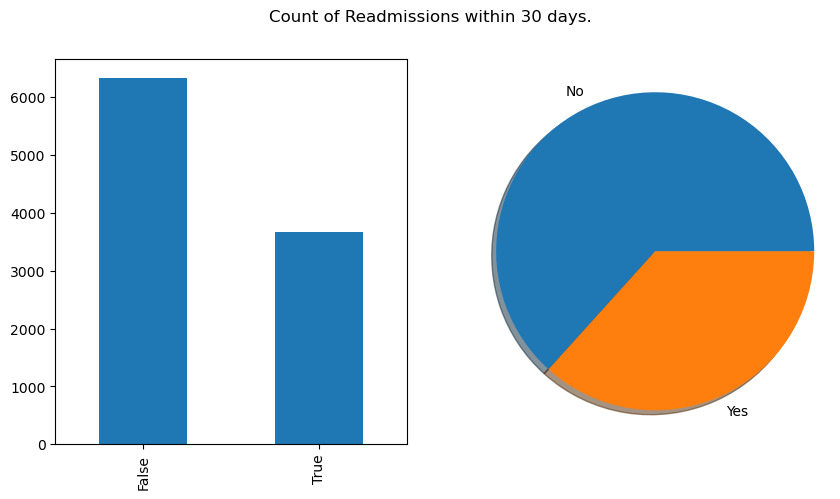

In [9]:
## Readmission
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
df.readmission.value_counts().plot(kind='bar')

plt.subplot(1, 2, 2)
plt.pie(df.readmission.value_counts(normalize=True),
        labels = ['No', 'Yes'], shadow=True)
plt.axis('equal')
plt.suptitle('Count of Readmissions within 30 days.')
plt.show()

***Numerical Variables***

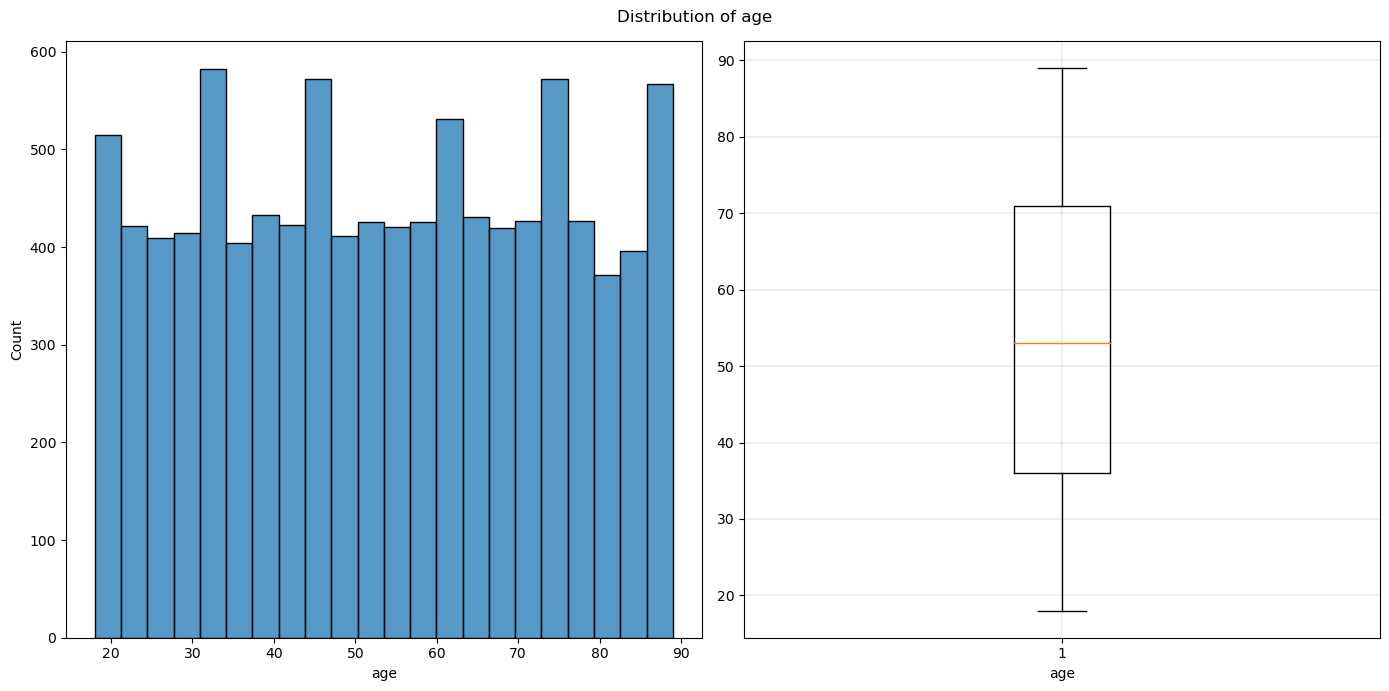

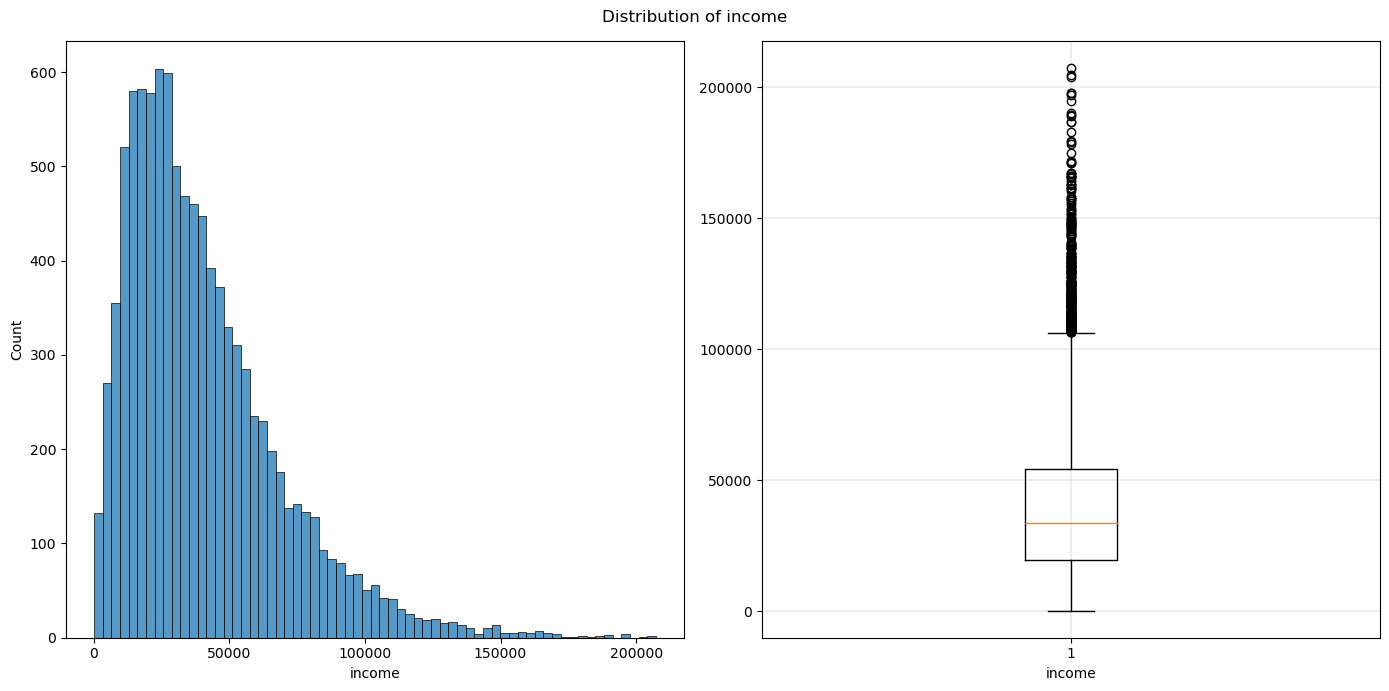

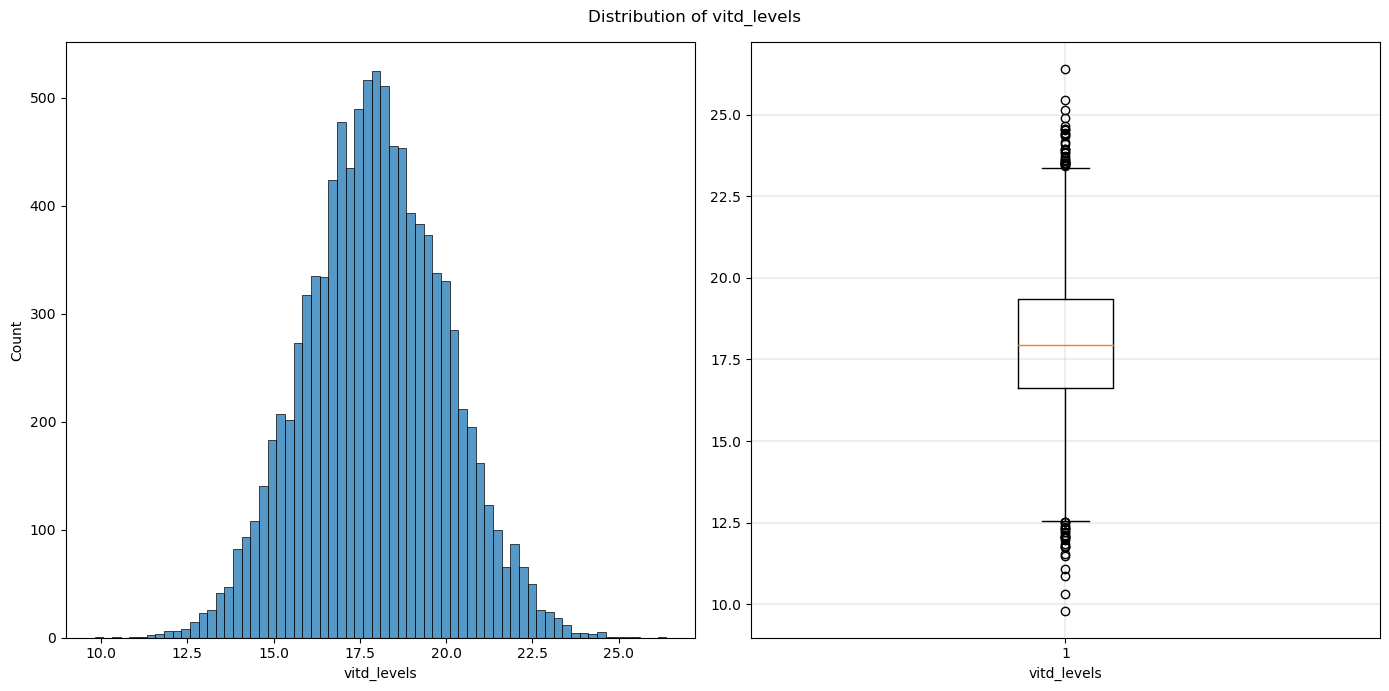

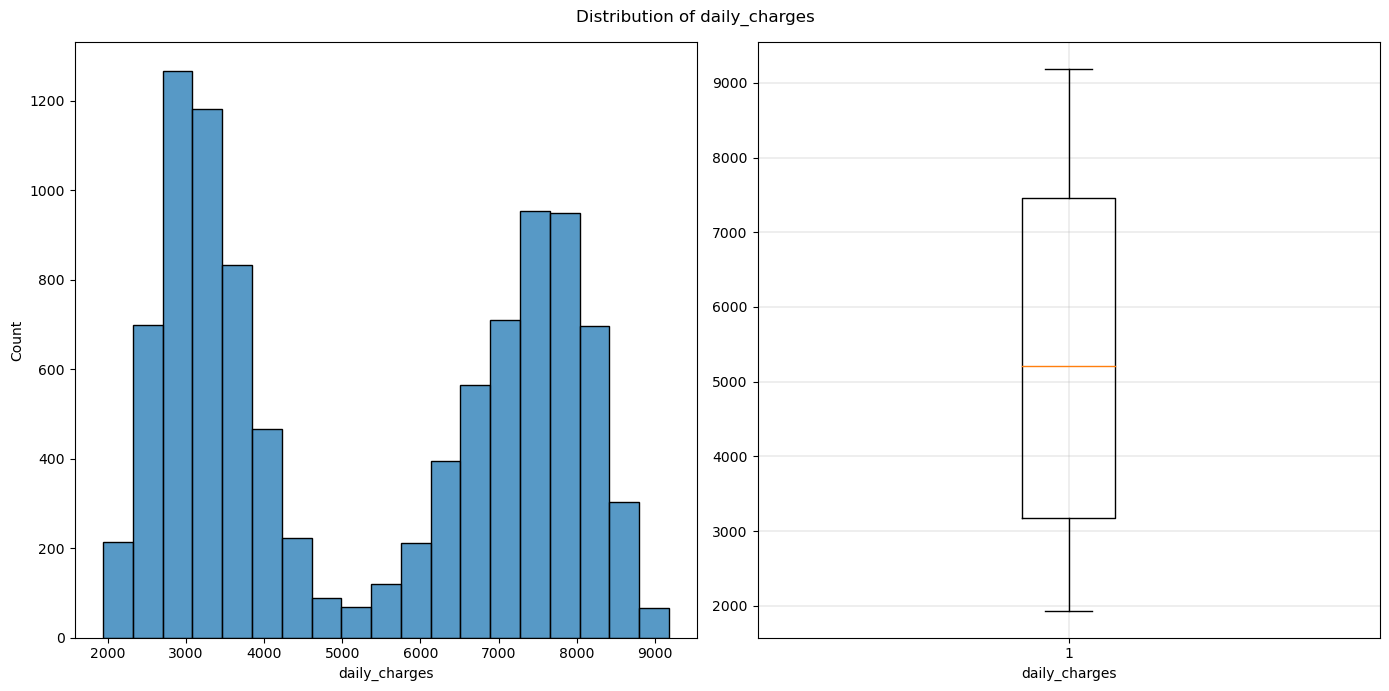

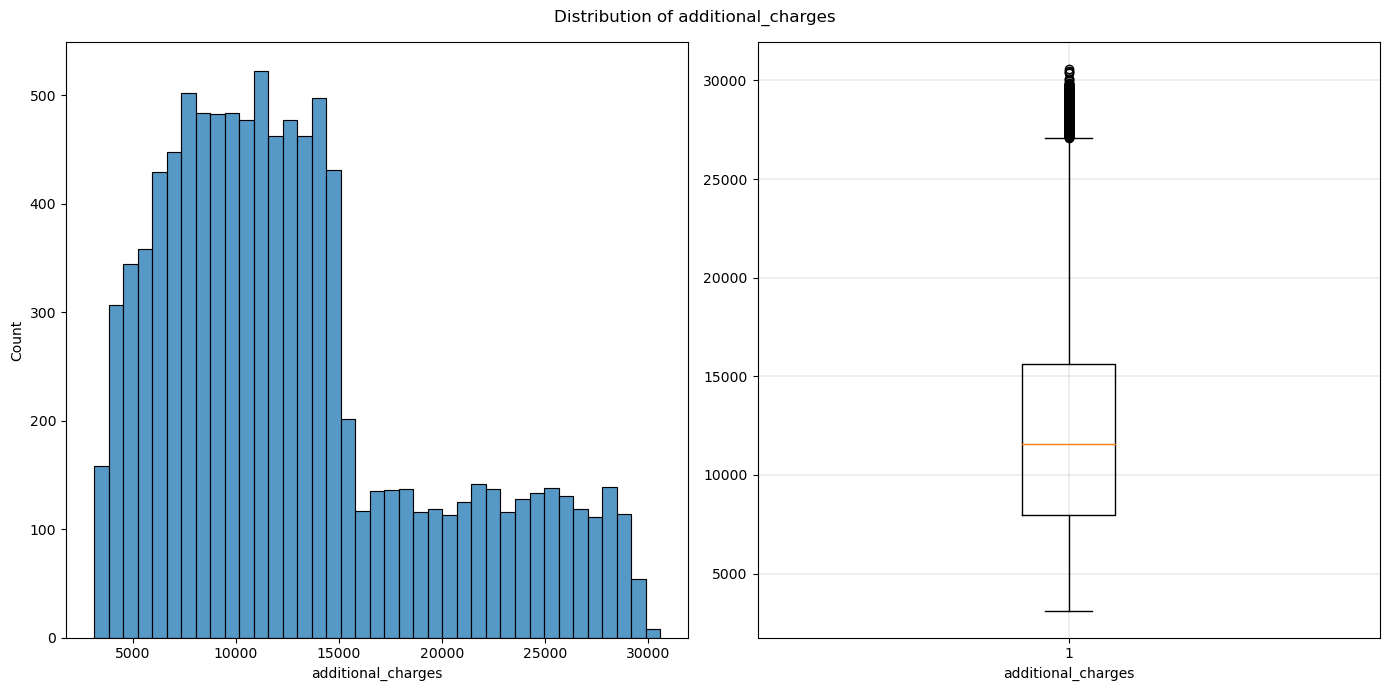

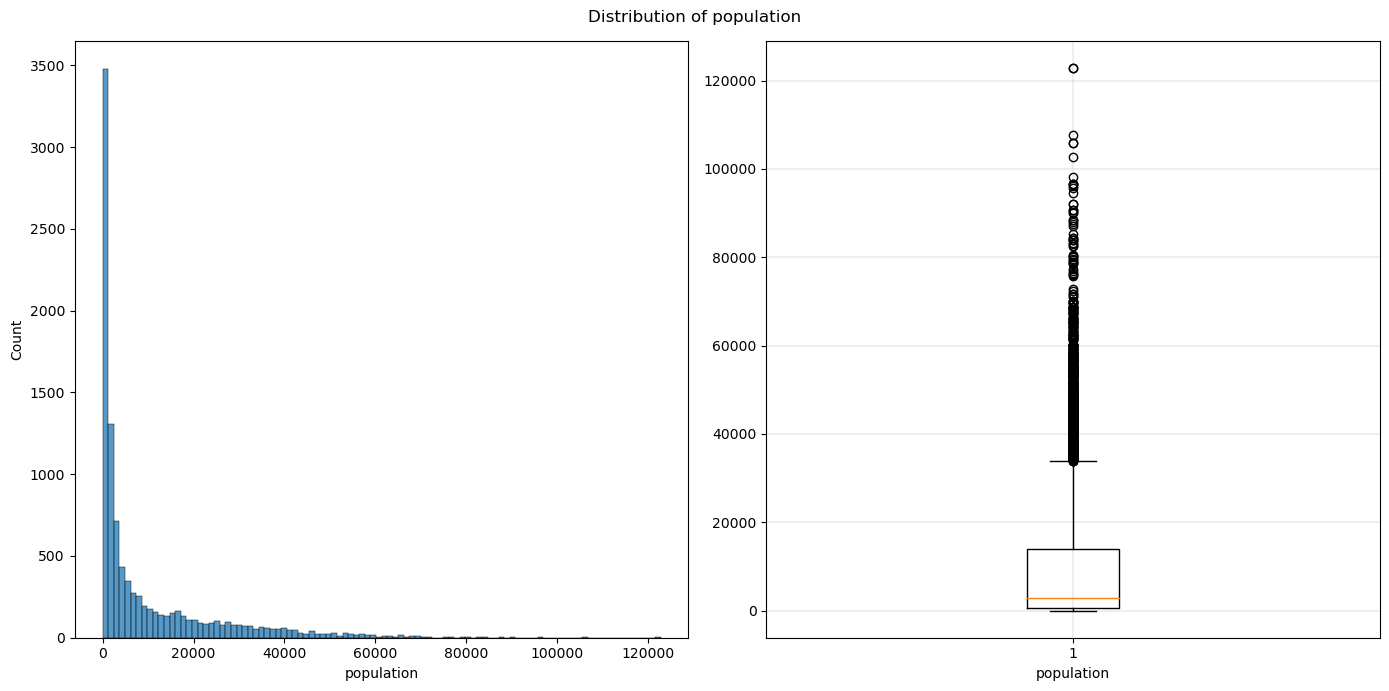

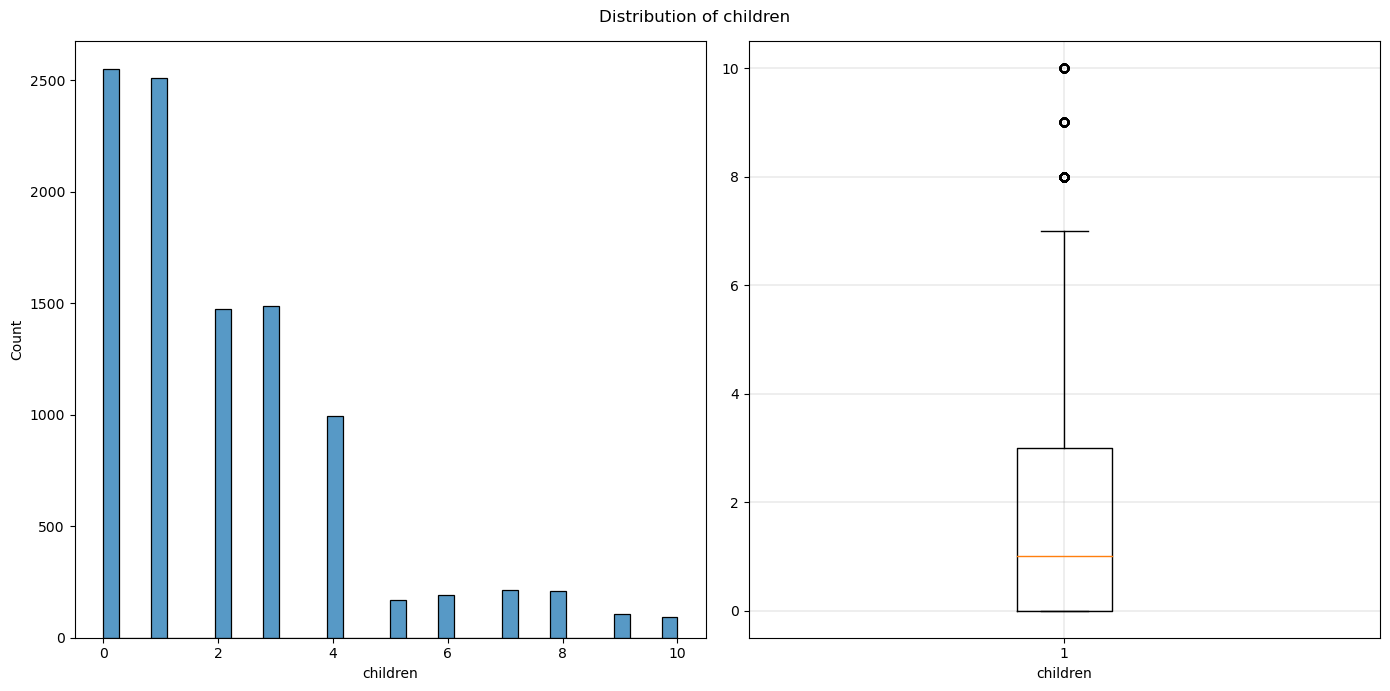

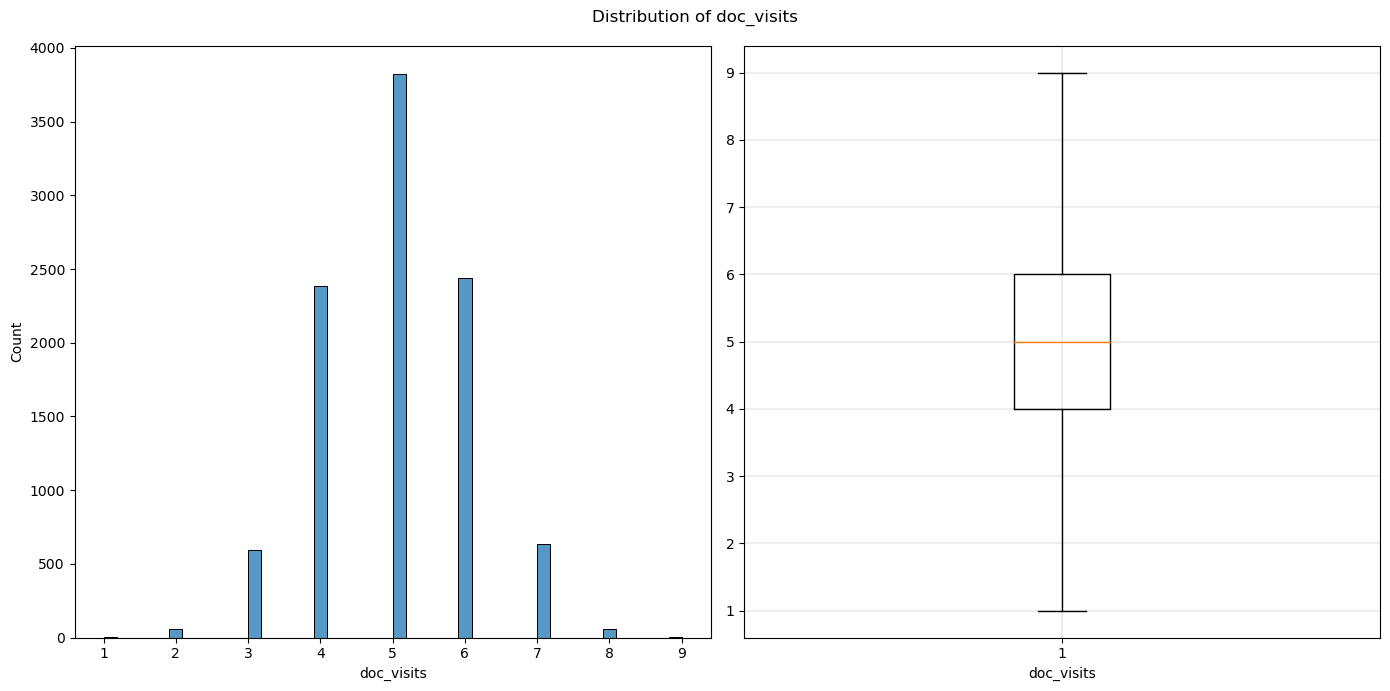

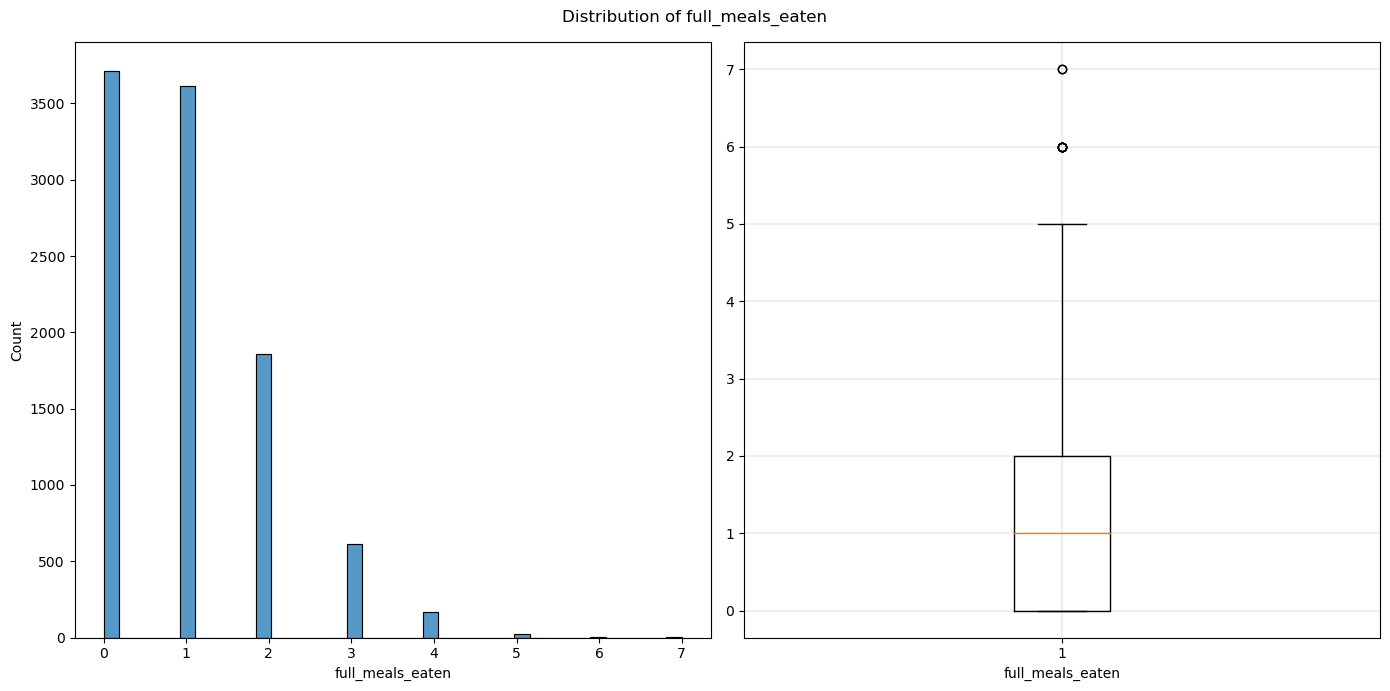

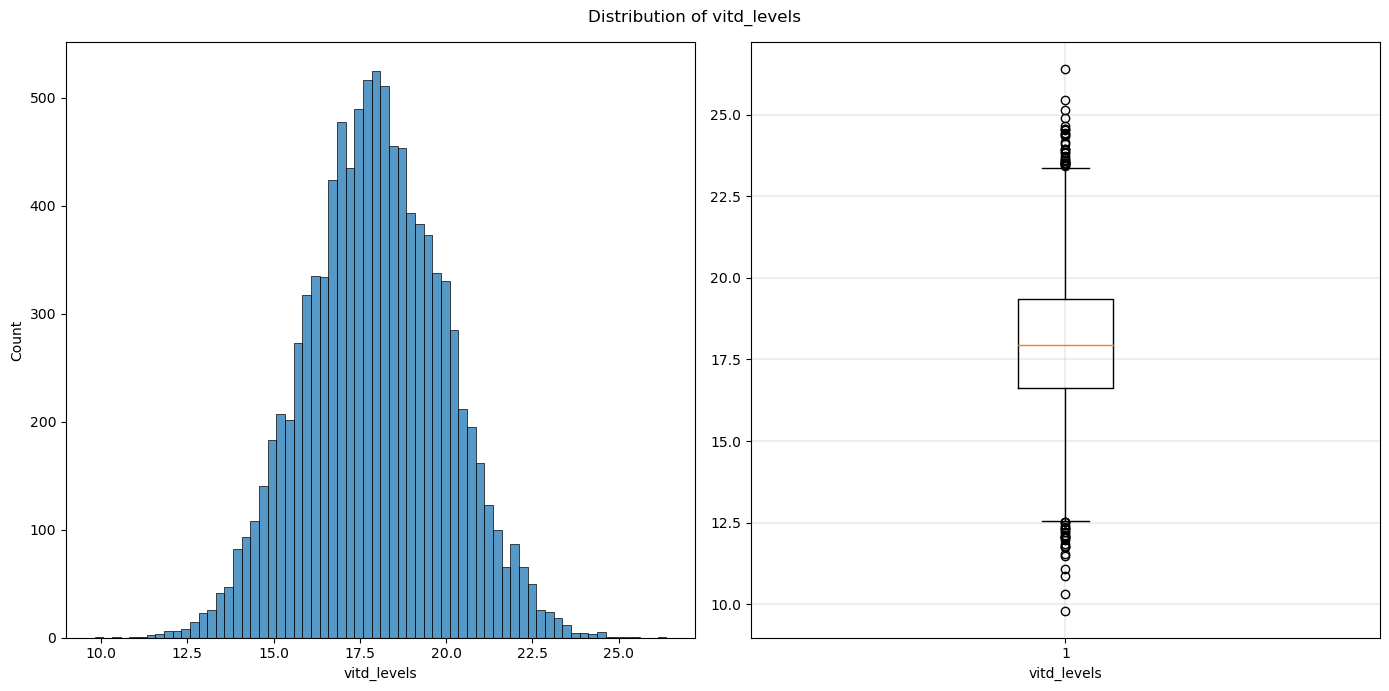

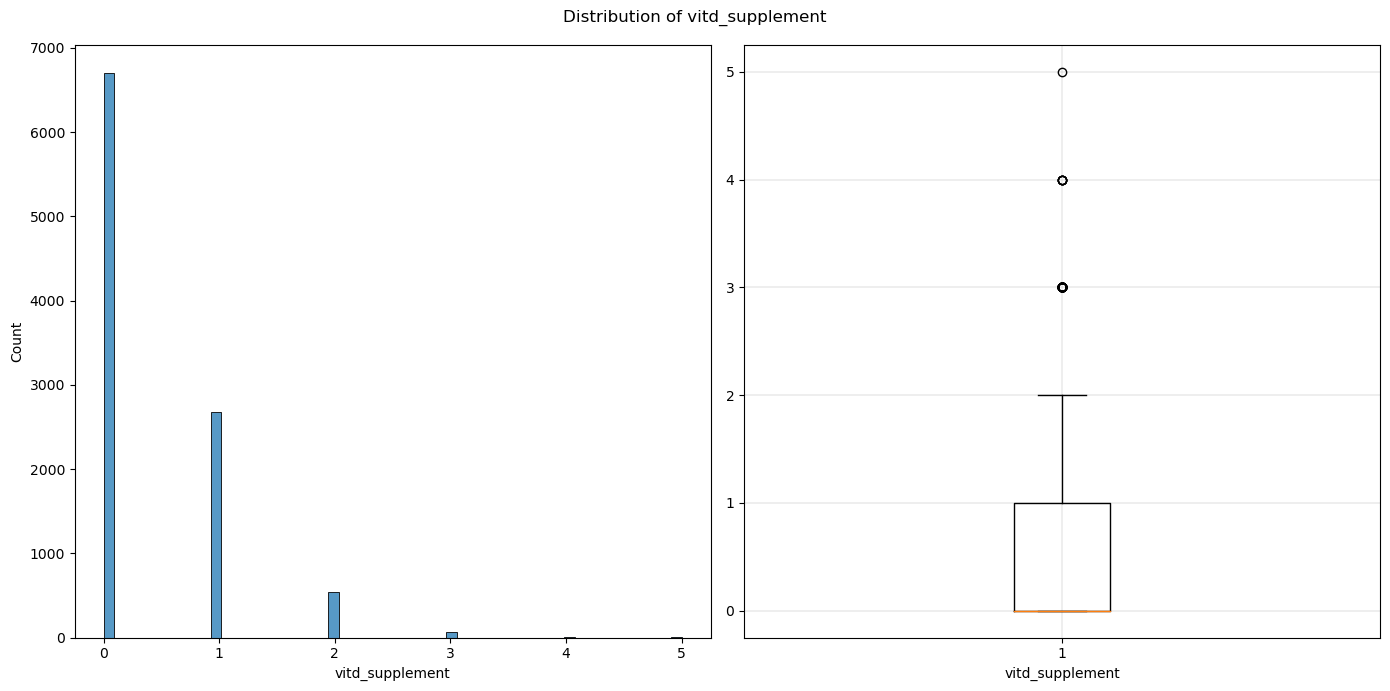

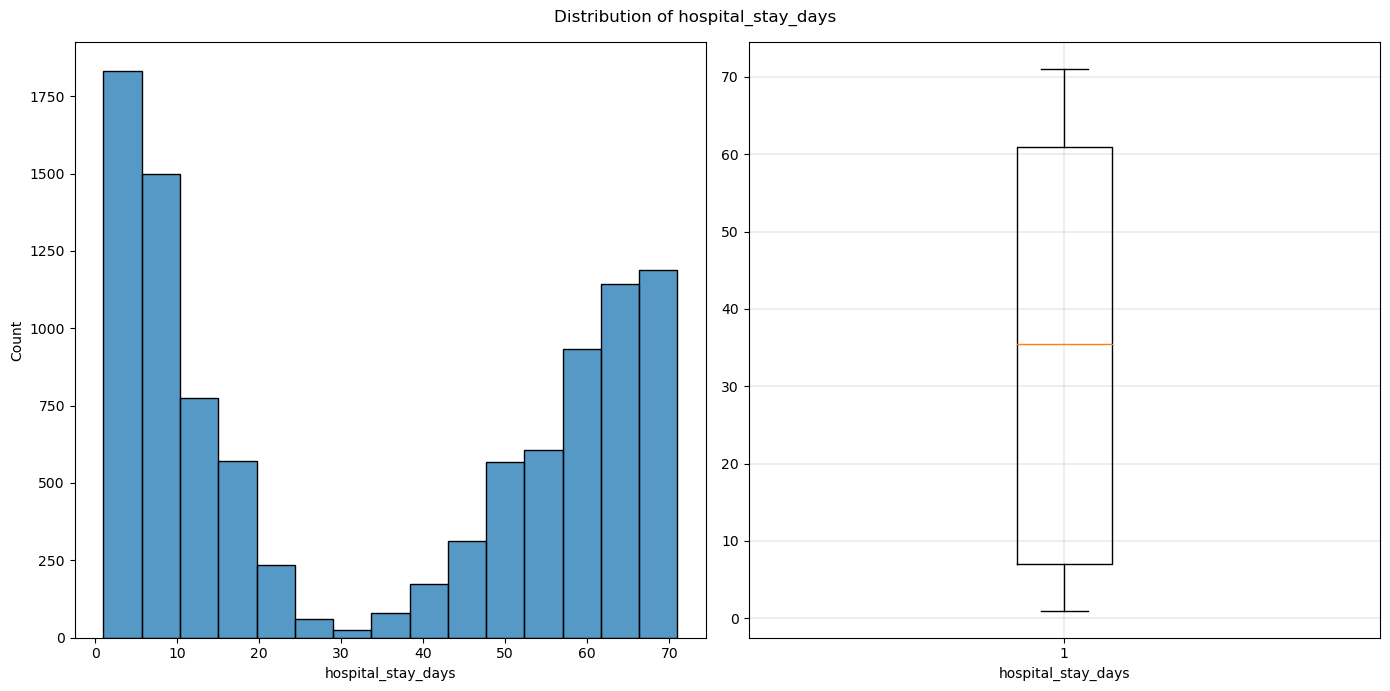

In [10]:
# distribution plot along with boxplot
for col in ordinal_vars:
    plt.figure(figsize=(14, 7))
    
    # hist
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=col)
    
    plt.xlabel(col)
    
    # boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(df[col])
    plt.xlabel(col)
     
    plt.grid(linewidth=0.3)    
    plt.suptitle(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

***Categorical Variables***

Distribution for categorical variables:


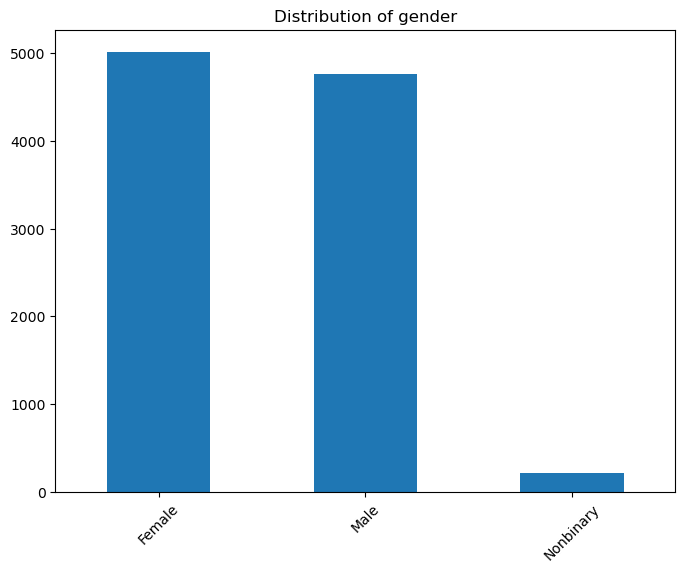

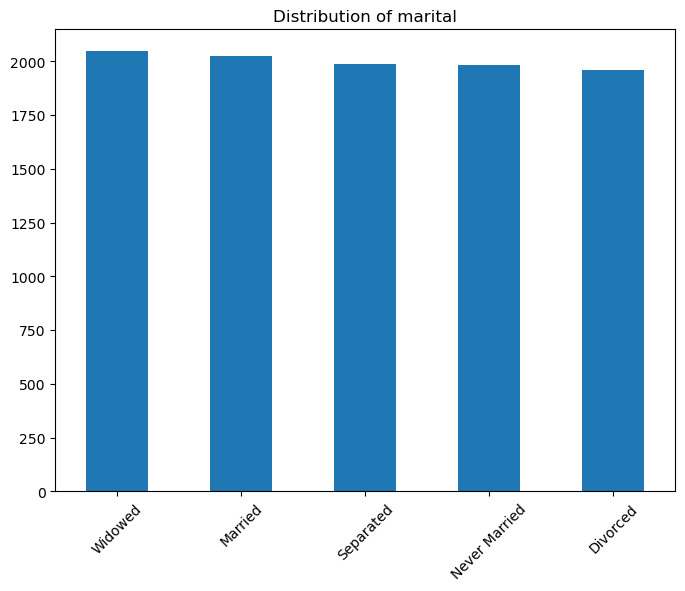

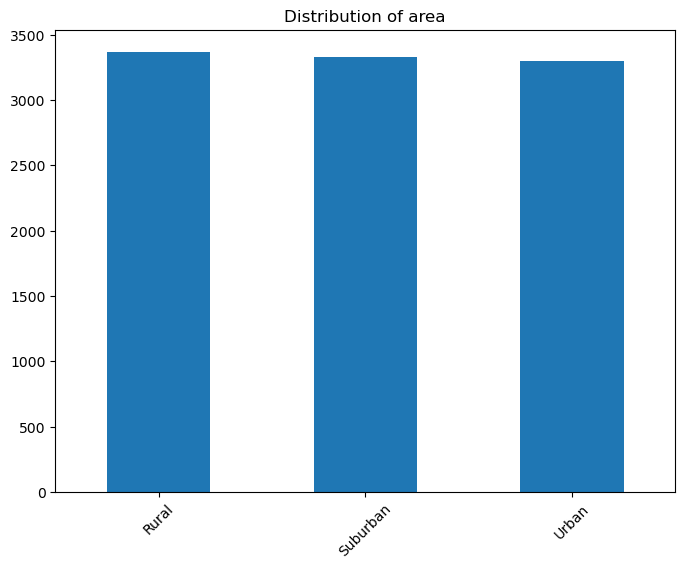

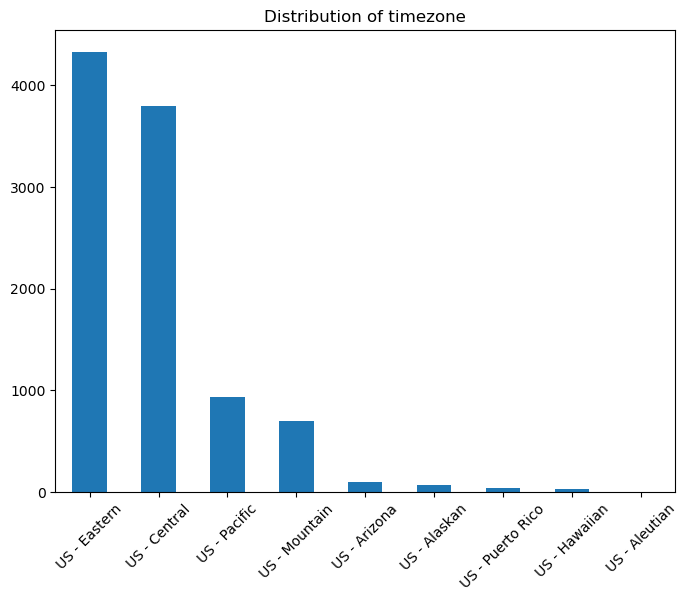

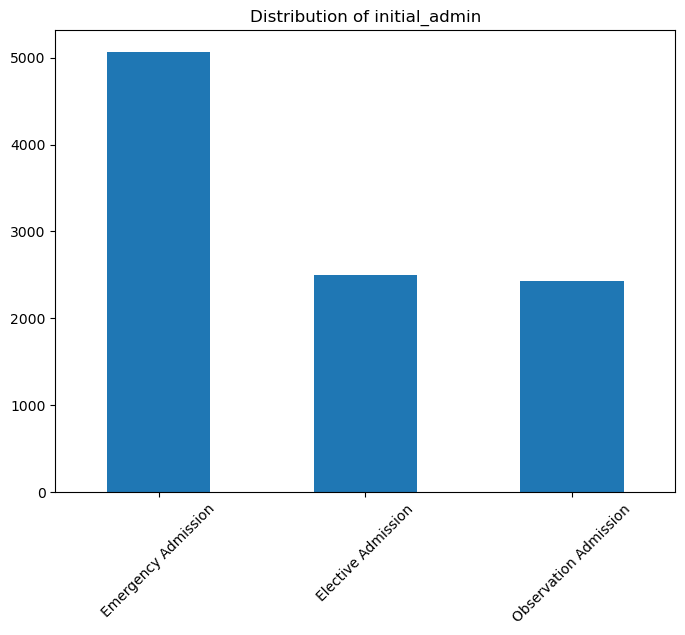

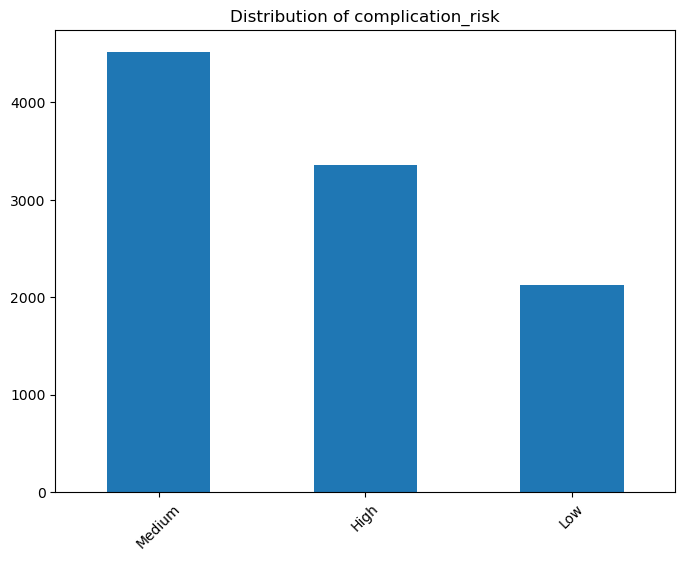

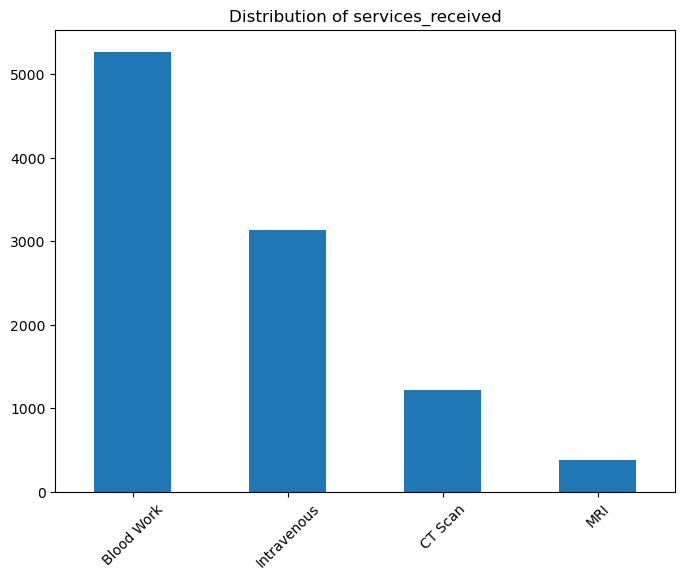

In [11]:
# distribution of categorical variables
print('Distribution for categorical variables:')
for var in cat_vars:
    plt.figure(figsize=(8,6))
    df[var].value_counts().plot(kind='bar') 
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {var}')
    plt.show()

***Boolean Variables***

Frequency distribution for boolean variables:


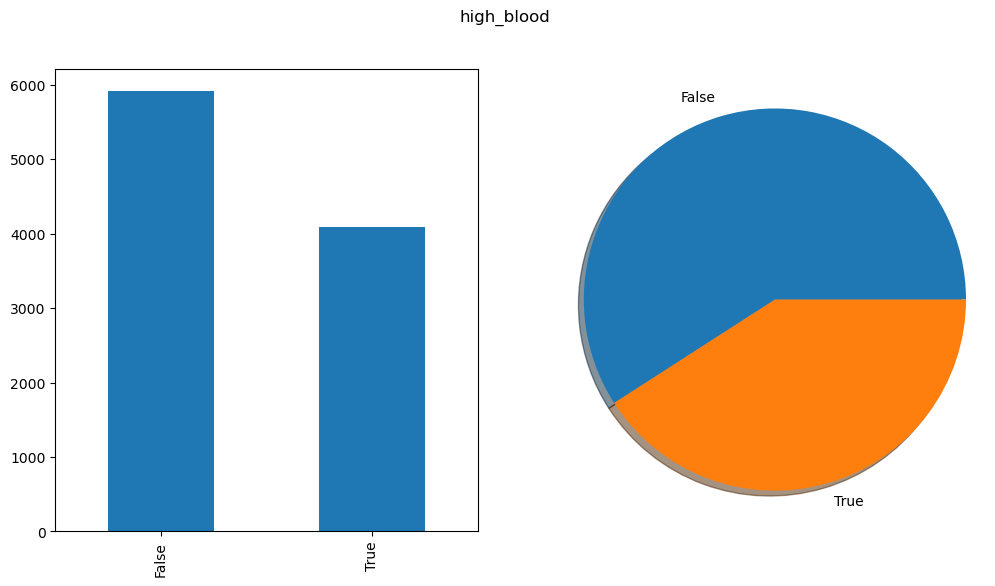

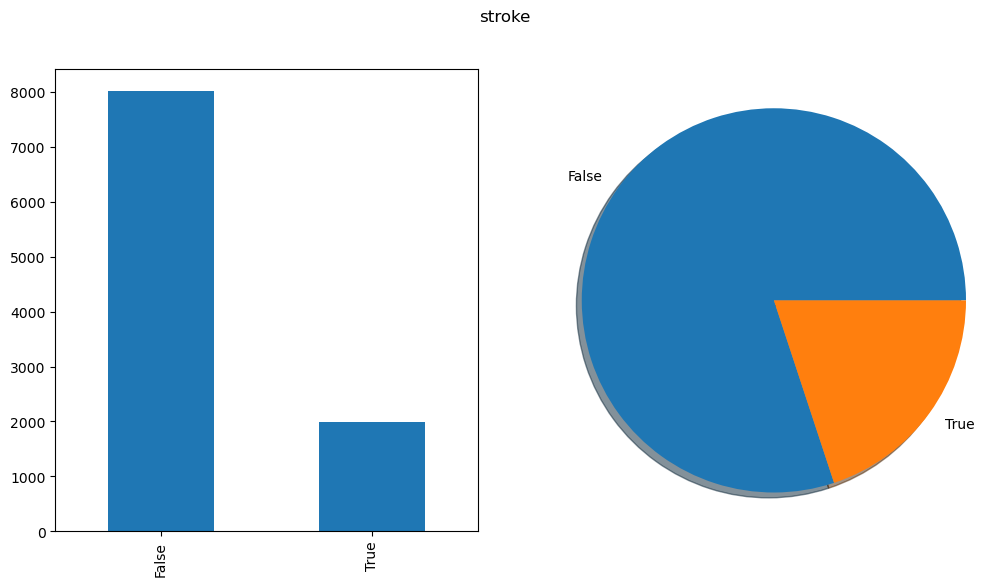

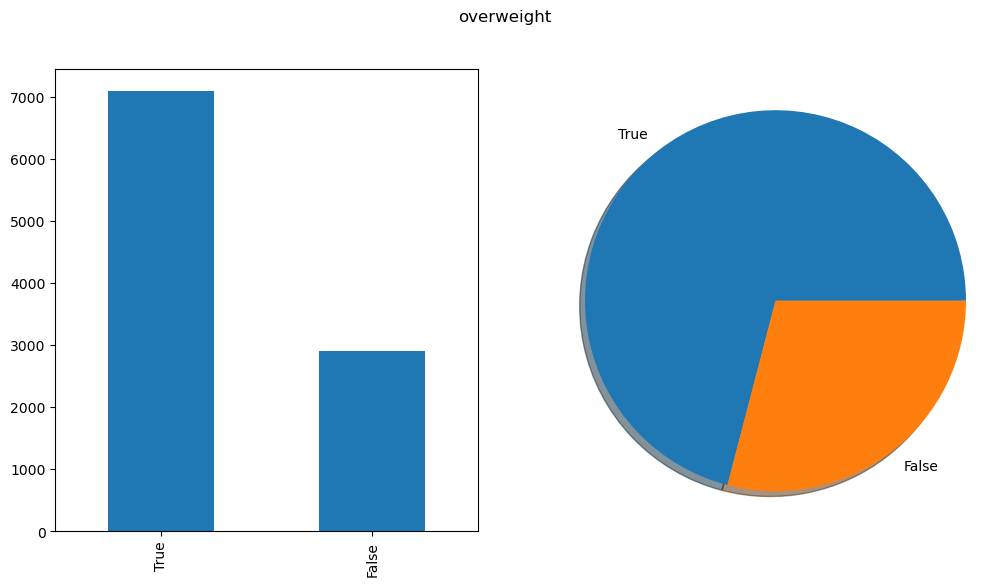

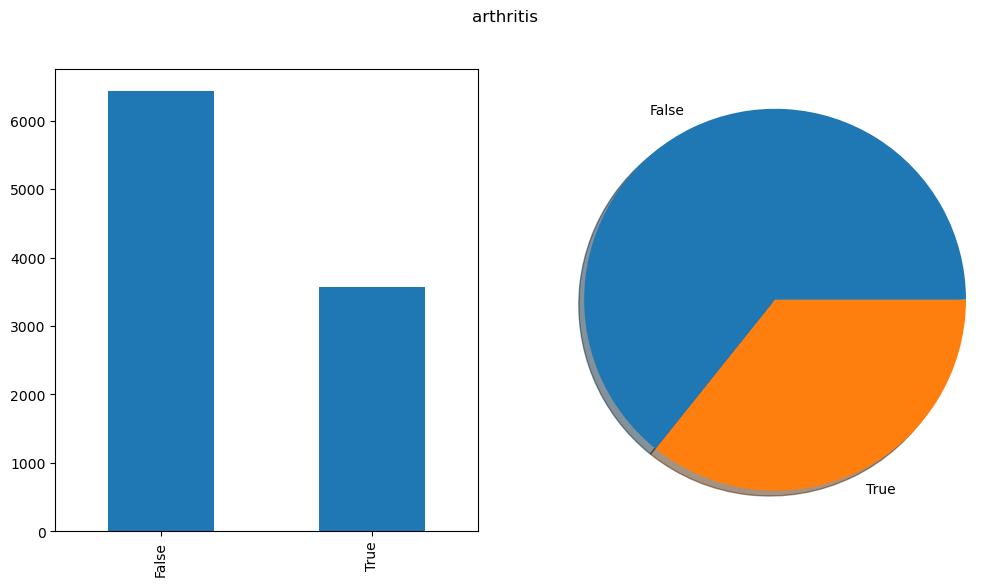

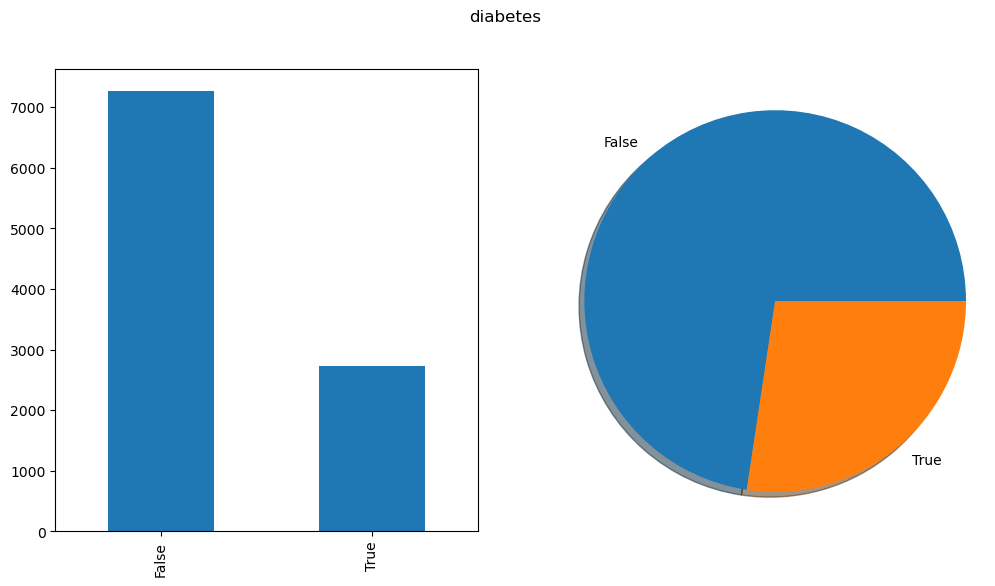

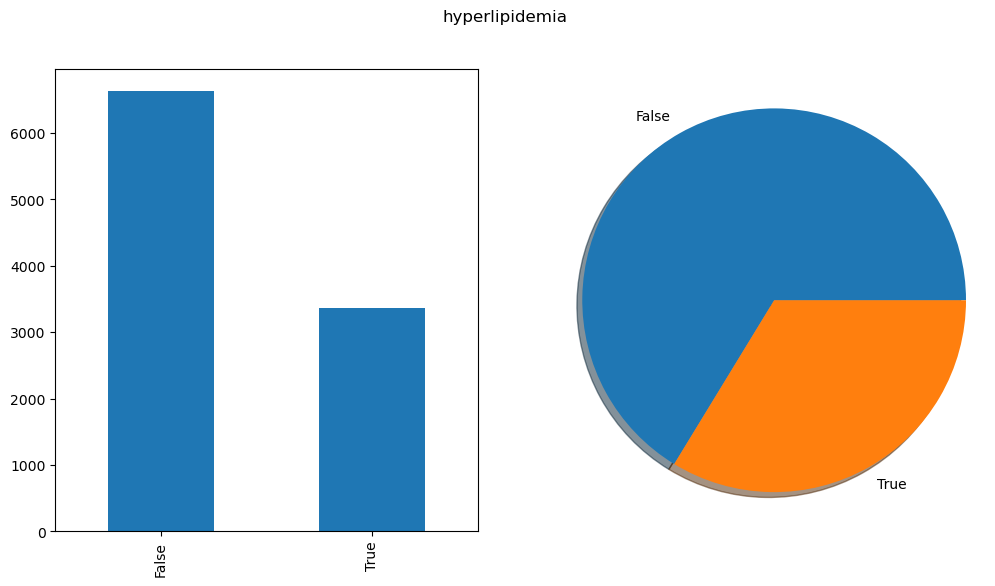

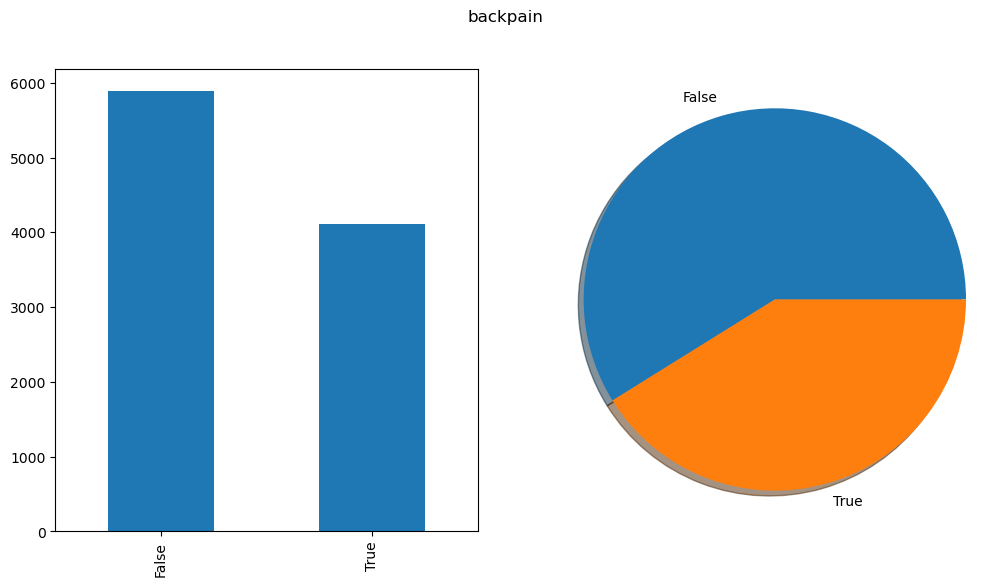

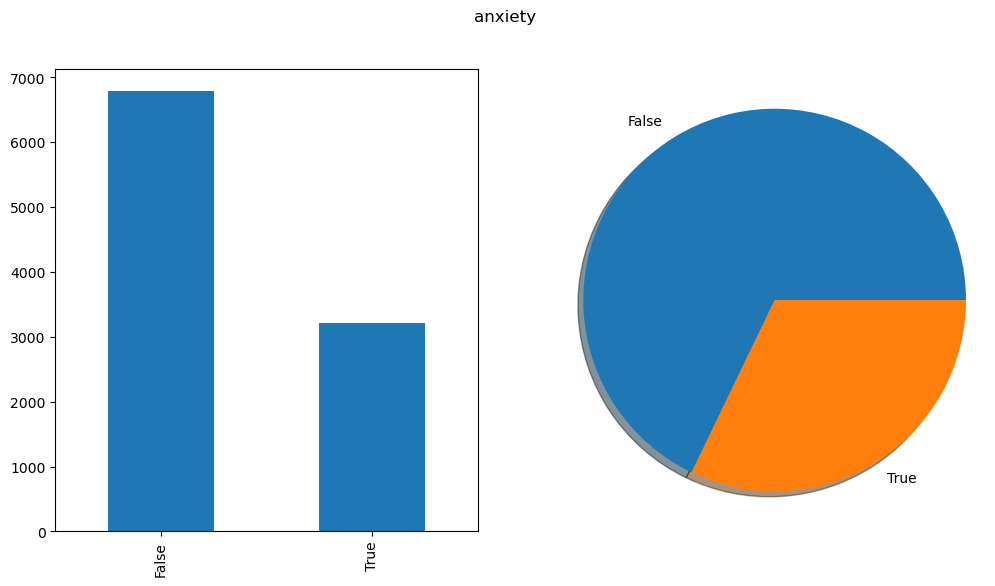

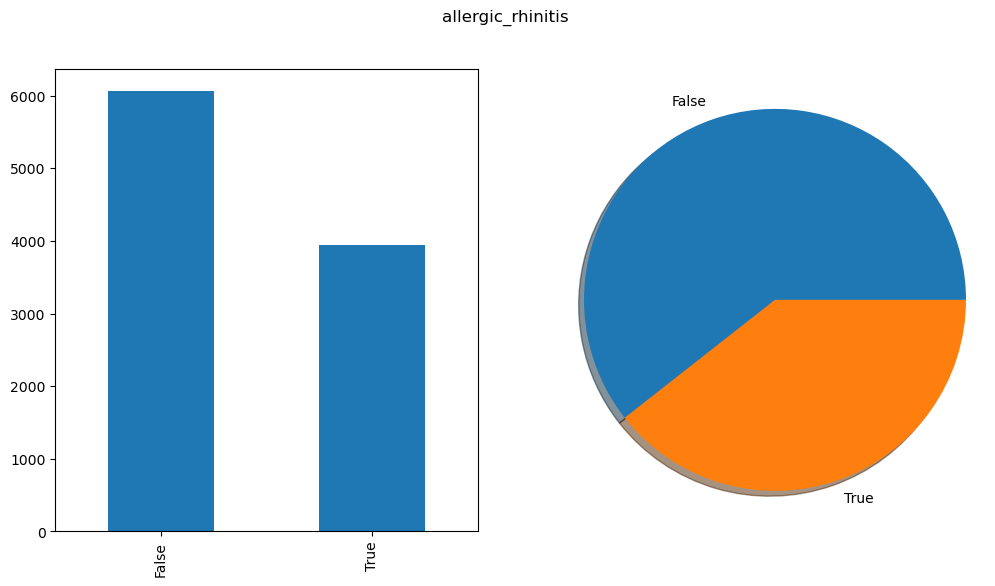

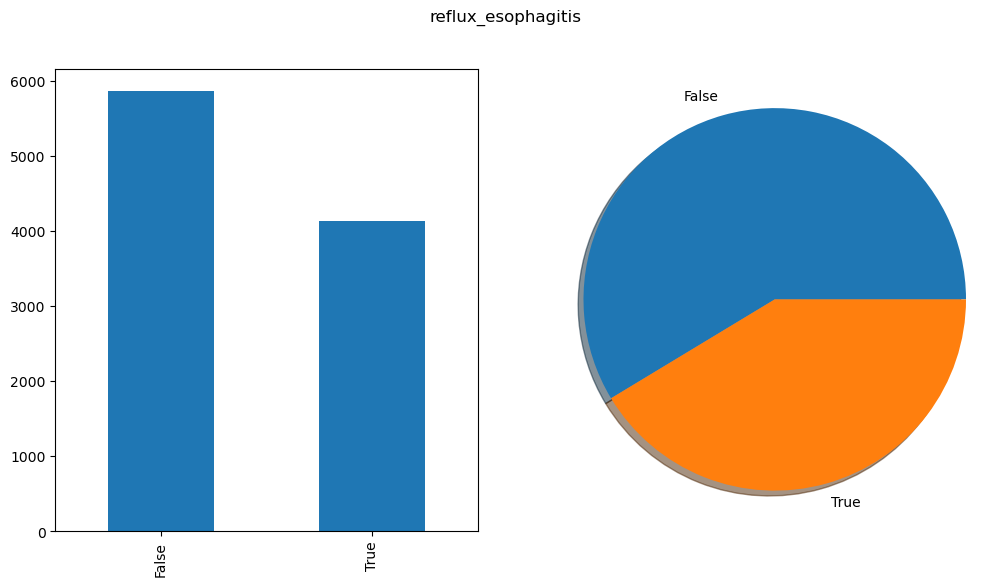

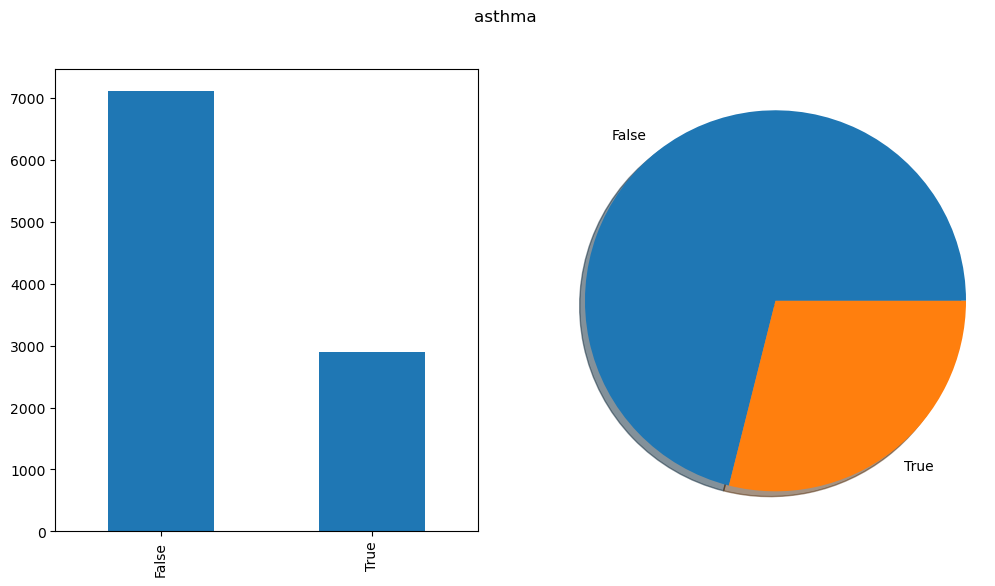

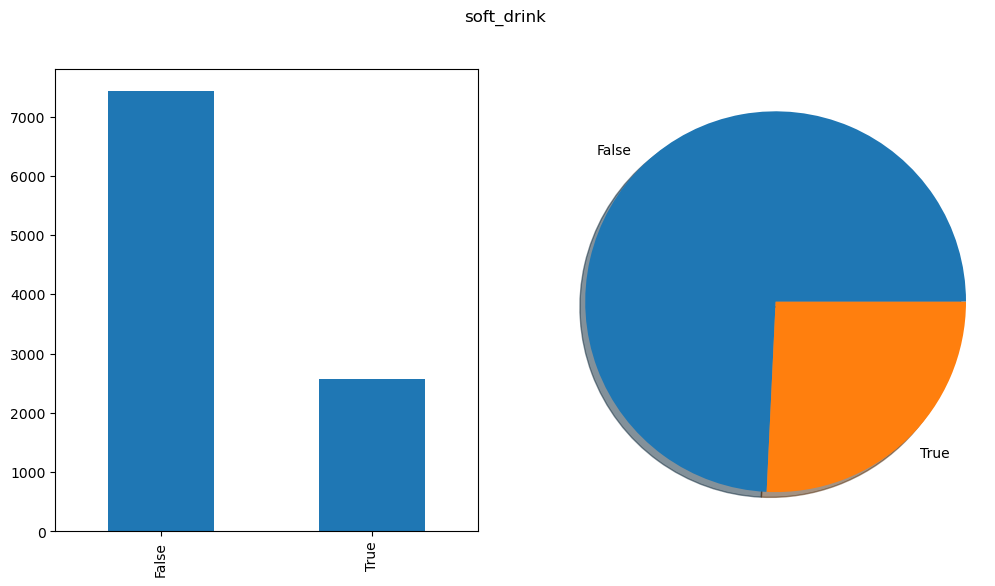

In [12]:
# Frequency distribution for boolean variables
print('Frequency distribution for boolean variables:')
for col in boolean_vars:
    plt.figure(figsize=(12,6))
#     print(f'\n{col}:')
    plt.subplot(1, 2, 1)
    df[col].value_counts().plot(kind='bar')
    
    plt.subplot(1, 2, 2)
    val_counts_dict = dict(df[col].value_counts())
    
    v = list(val_counts_dict.values())
    k = list(val_counts_dict.keys())
    plt.pie(v, labels = k, shadow=True)
    plt.axis('equal')
    plt.suptitle(col)
    plt.show()

#### Bivariate Visualizations

***Readmissions versus numerical variables***

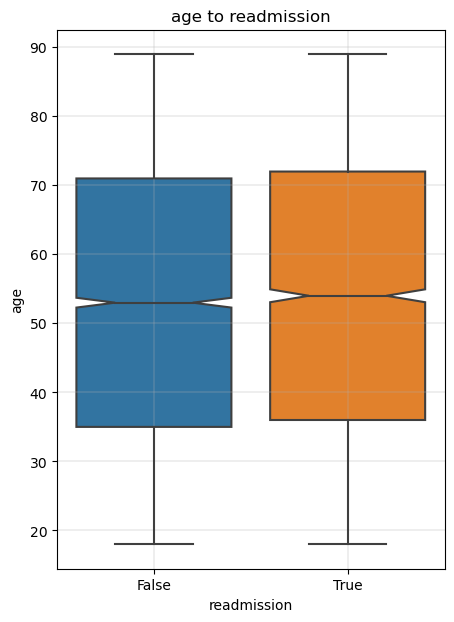

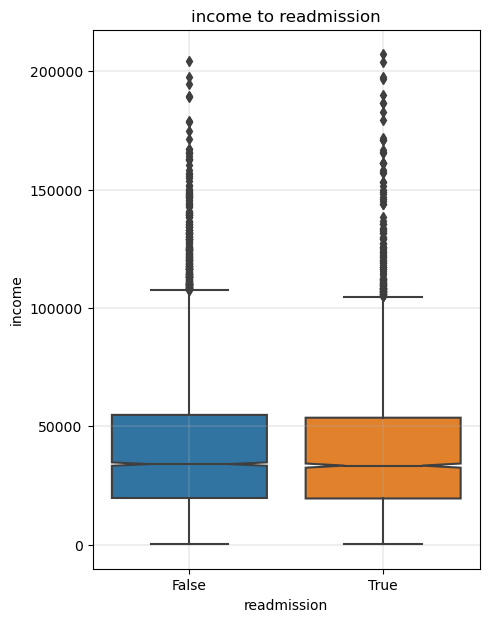

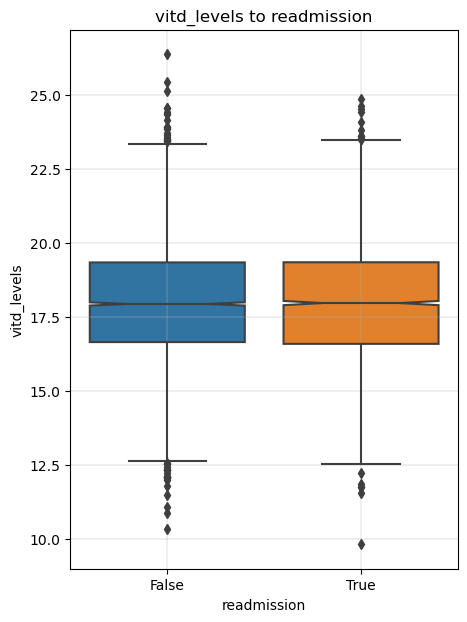

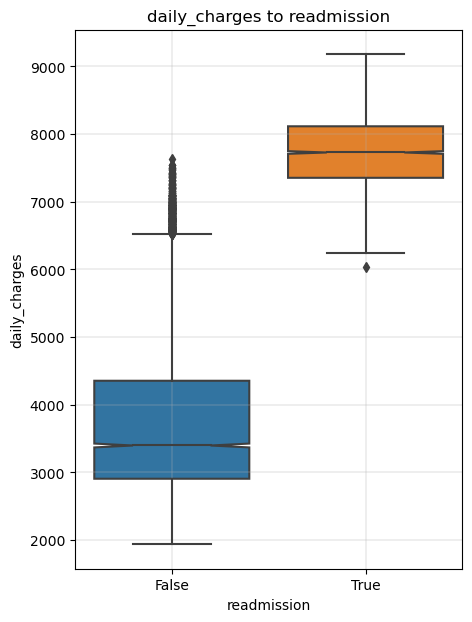

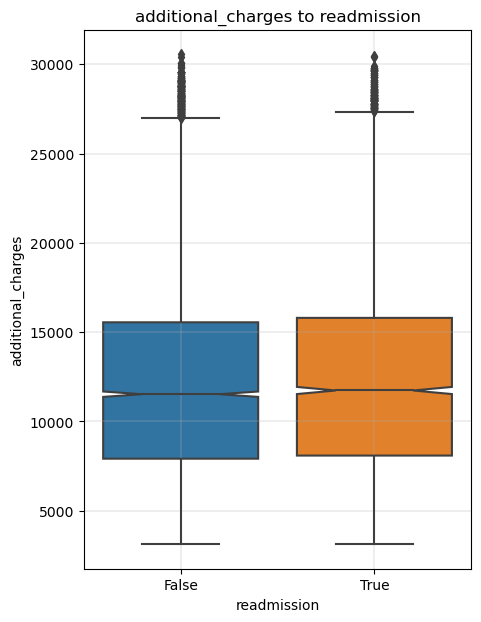

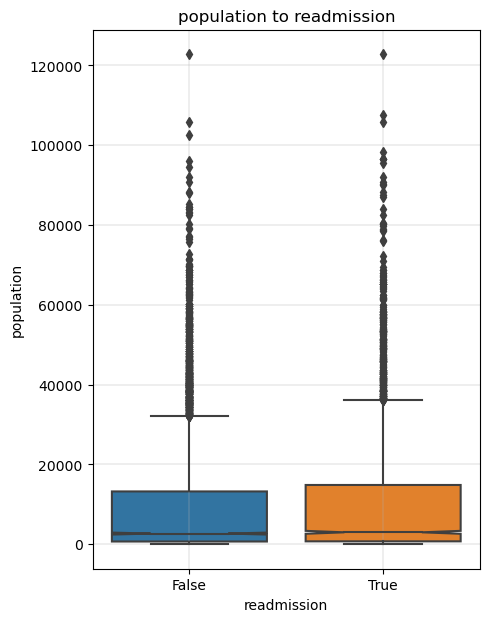

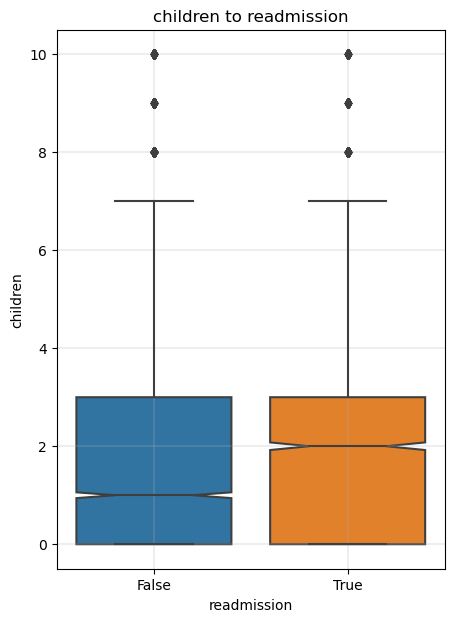

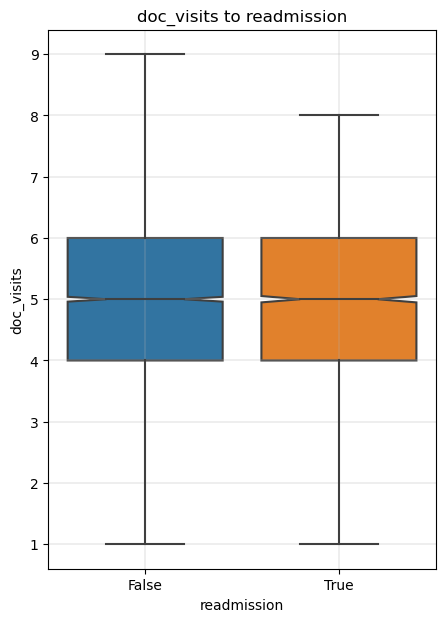

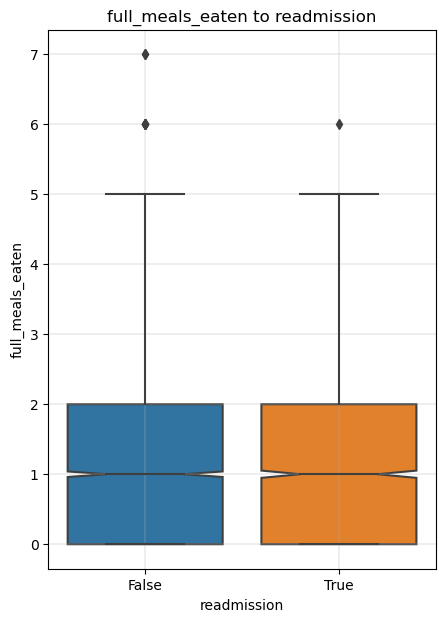

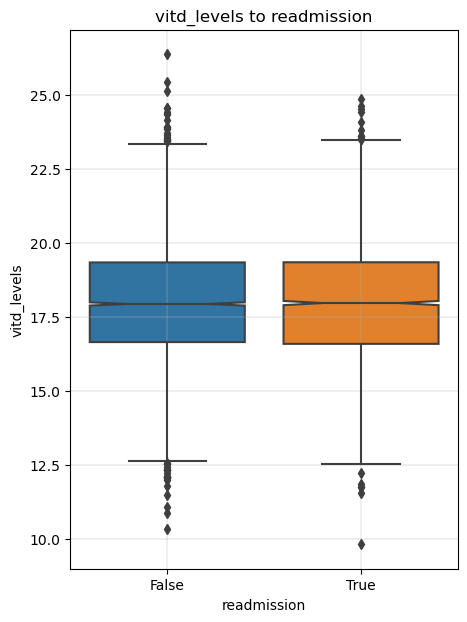

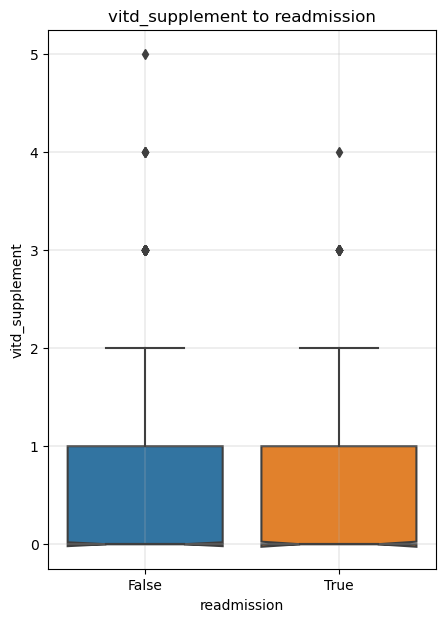

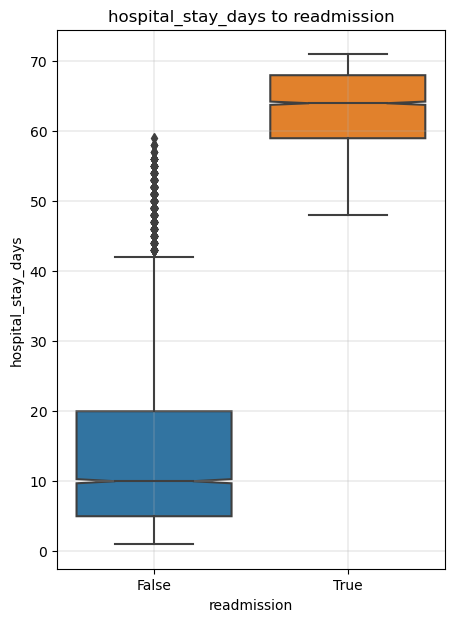

In [13]:
for i in ordinal_vars:
    plt.figure(figsize=(5,7))
    sns.boxplot(y=i, x='readmission', data=df, notch=True)
    plt.title(f'{i} to readmission')
    plt.grid(linewidth=0.3)
    plt.show()

The bivariate visualizations are largely unremarkable, with minimal notable differences between variables. However, the comparison of daily charges to readmission stands out significantly. Patients with lower daily charges are far less likely to be readmitted, while those with higher charges tend to be readmitted within 30 days of discharge. Similarly, hospital stays show a positive association with readmission, where longer stays correspond to a higher likelihood of readmission. These trends suggest that higher daily costs and extended hospital stays could be indicators of more severe or complex cases, which naturally lead to higher readmission rates.

**Categorical v. Readmissions**

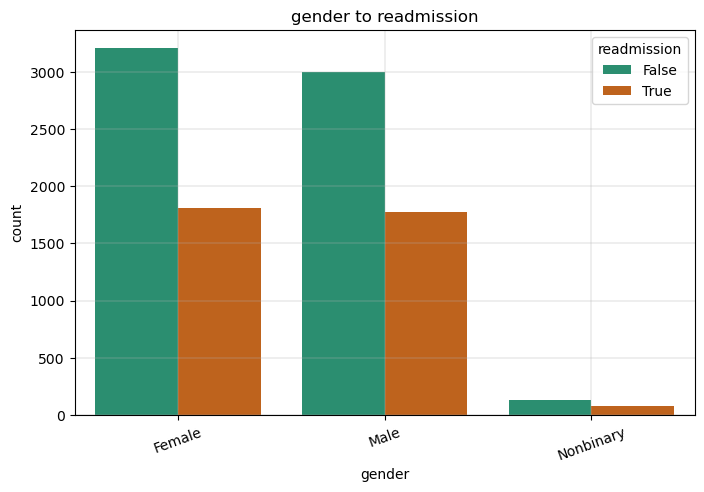

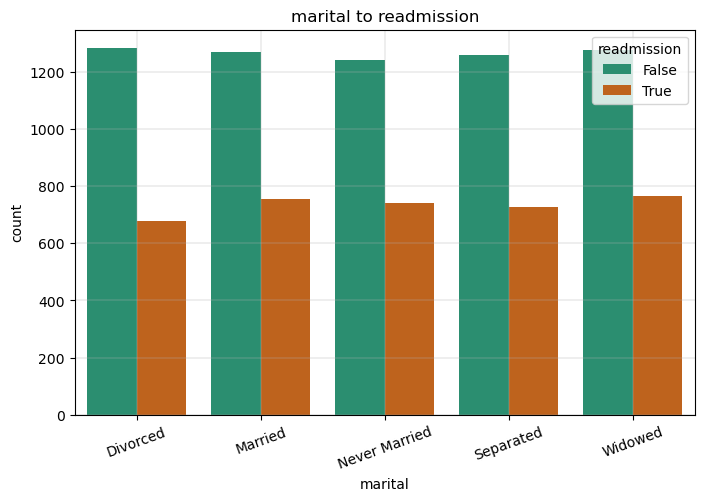

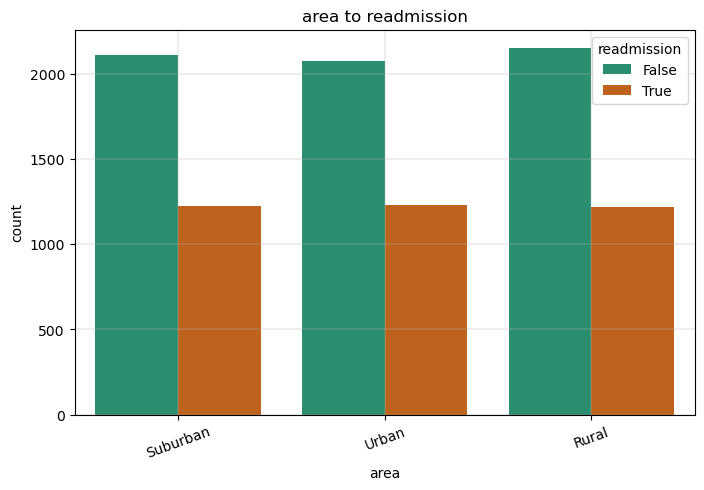

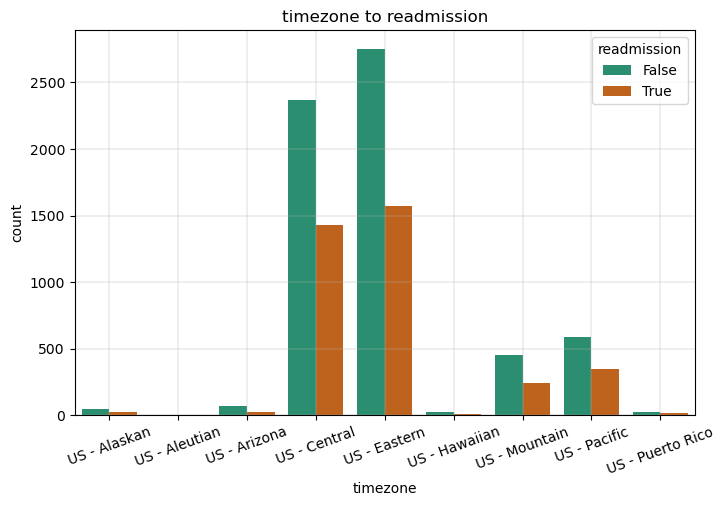

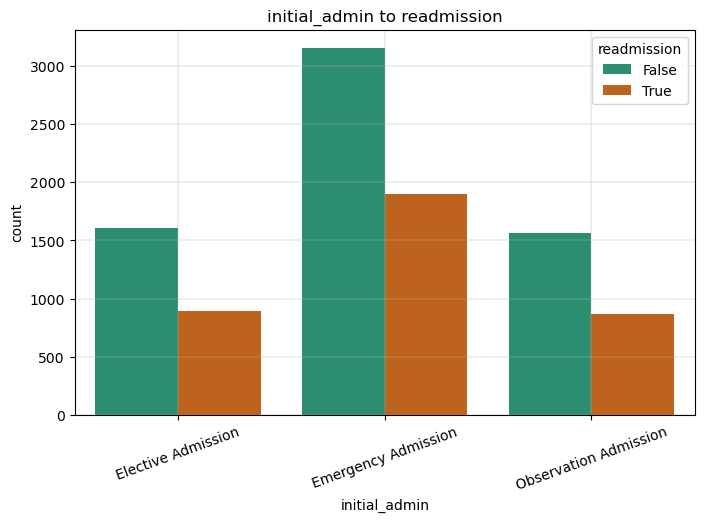

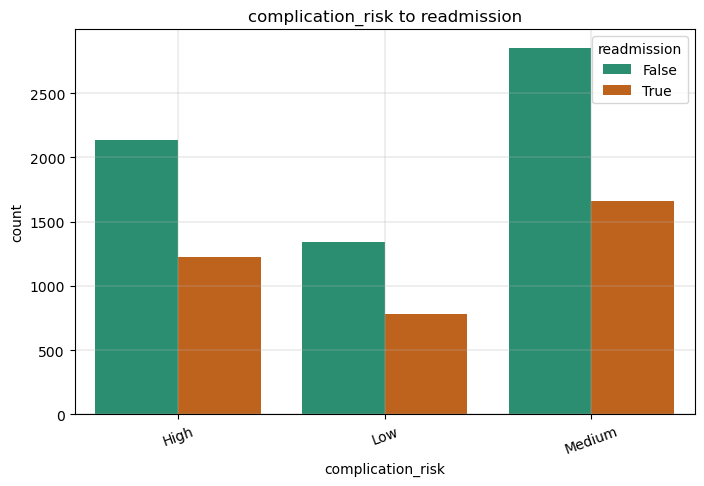

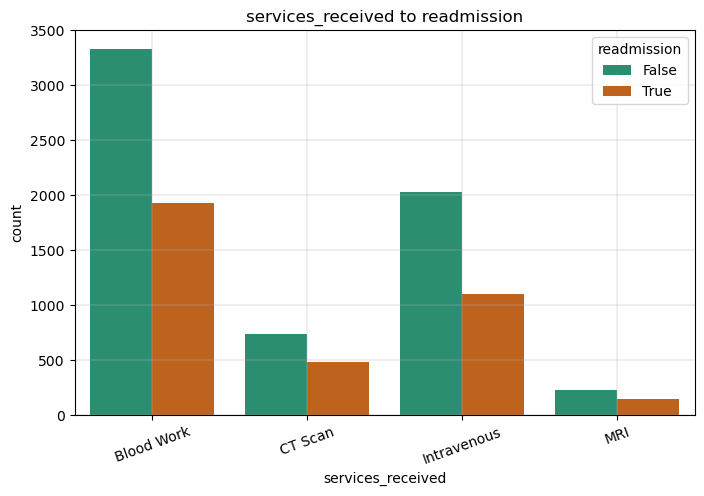

In [14]:
for i in cat_vars:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=i, hue='readmission', palette='Dark2')
    plt.title(f'{i} to readmission')
    plt.grid(linewidth=0.3)
    plt.xticks(rotation=20)
    plt.show()

The countplot reveals notable imbalances in both gender and services received. Nonbinary gender is significantly underrepresented, which could lead to unreliable correlations with readmissions. Additionally, services received shows a mild imbalance. These discrepancies should be tracked throughout the project to prevent biased or misleading results.

**Boolean v. Readmissions**

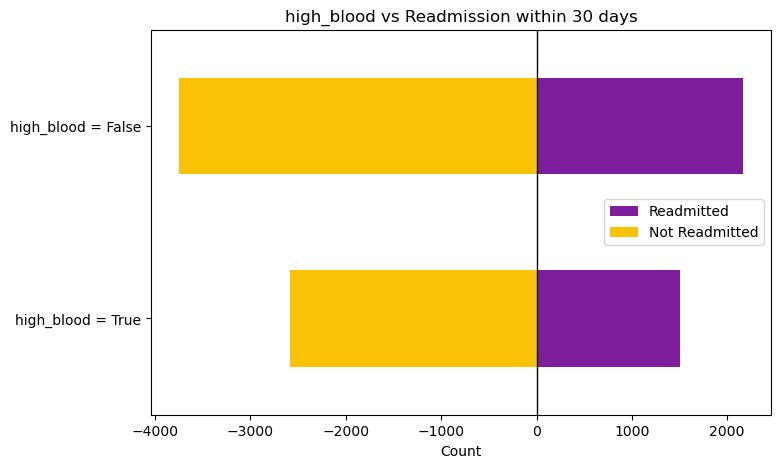

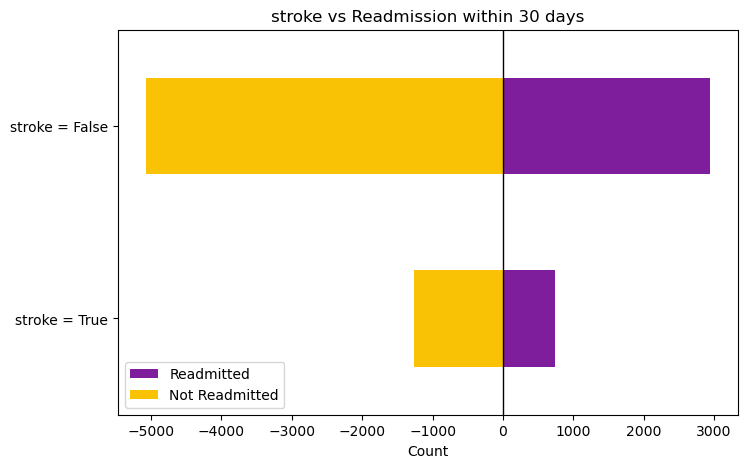

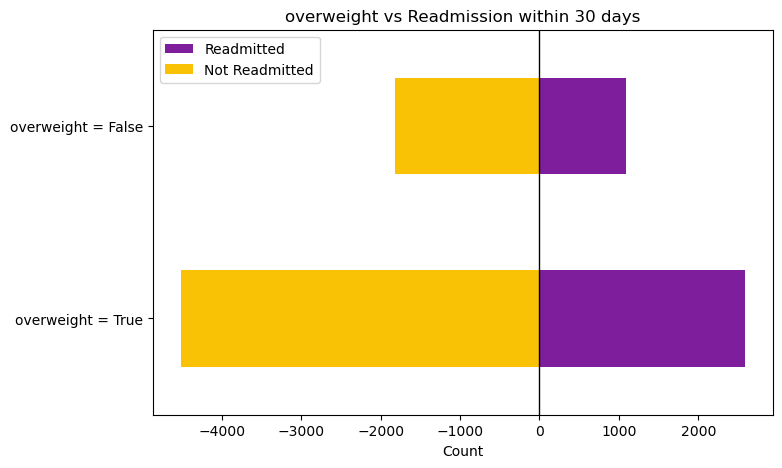

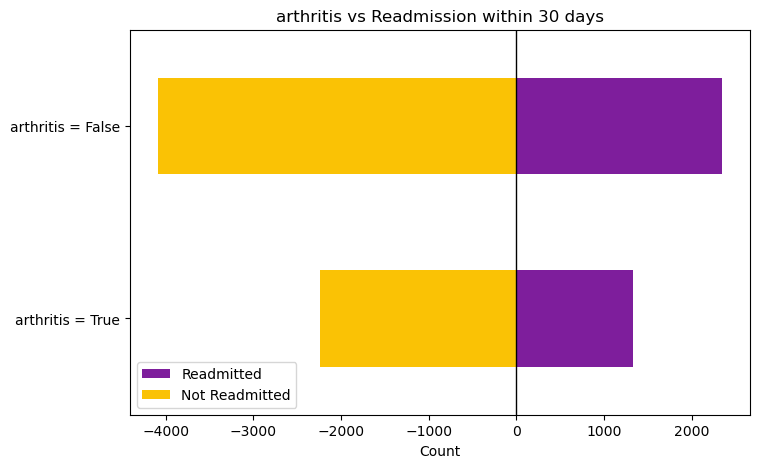

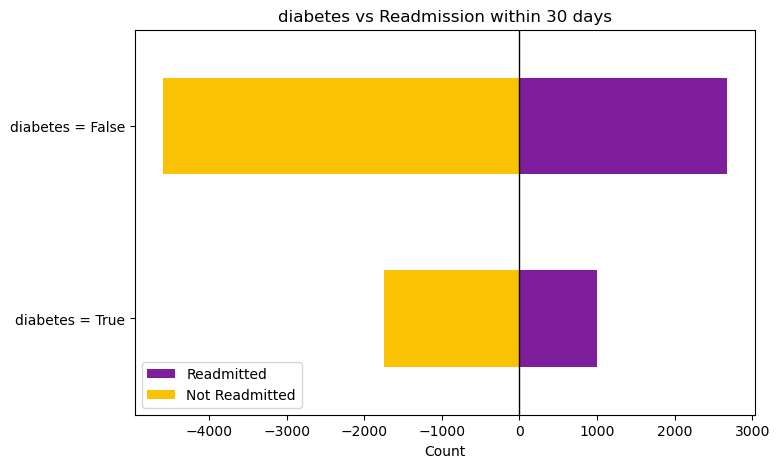

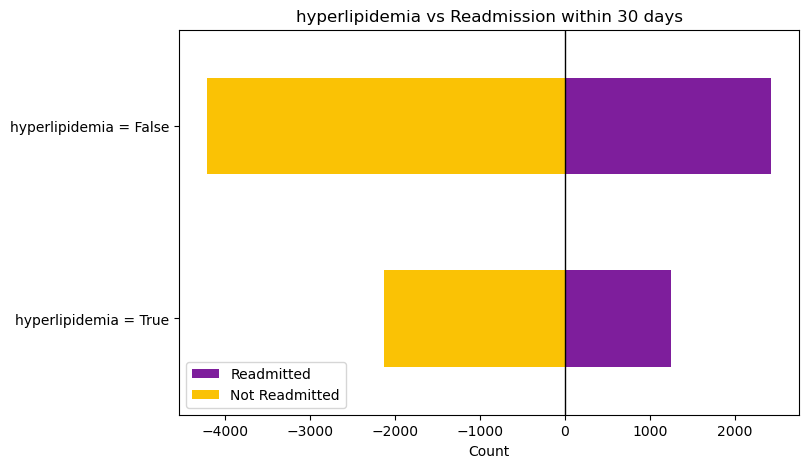

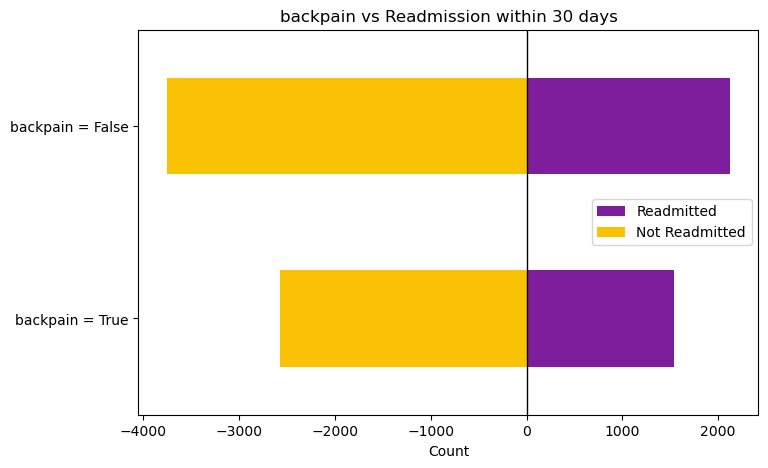

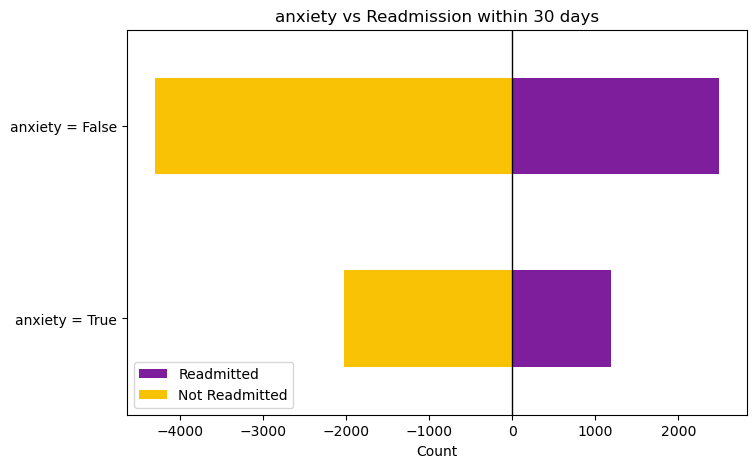

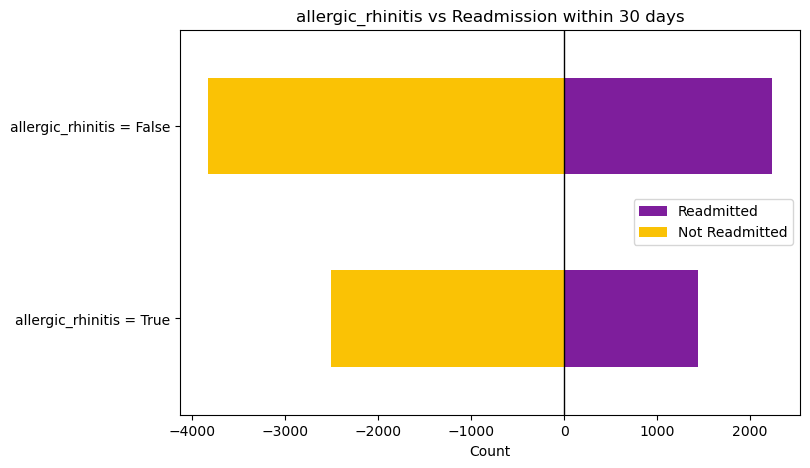

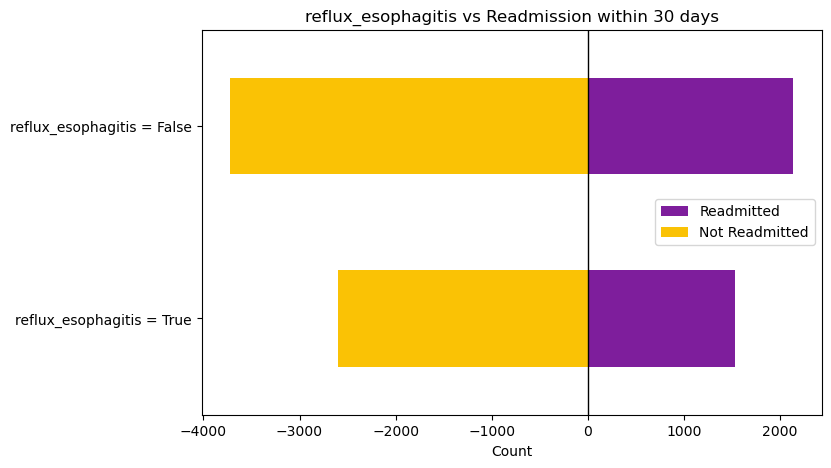

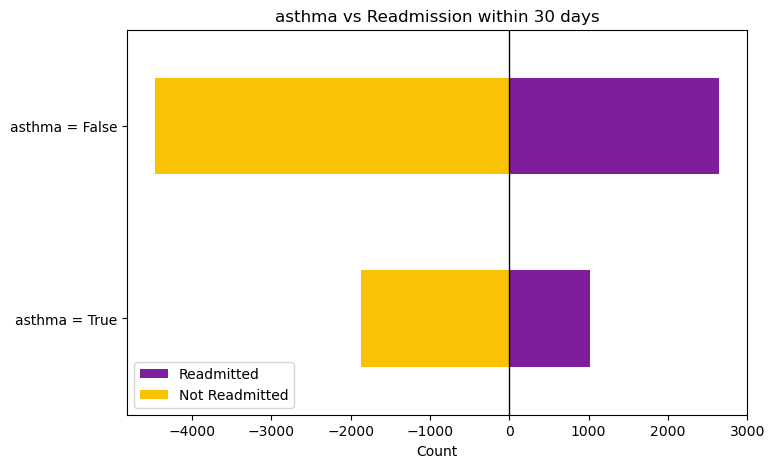

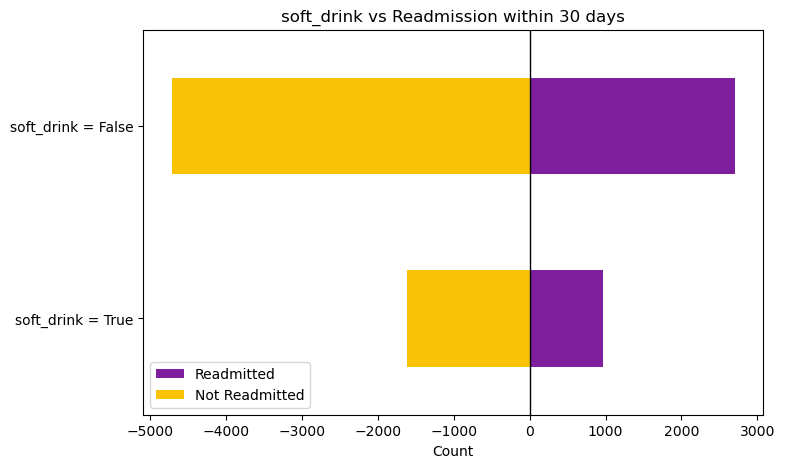

In [15]:
for i in boolean_vars:
    # crosstab of bool var vs. readmission
    crosstab = pd.crosstab(df[i], df['readmission'])
    
    # Prepare the data for diverging bar chart (positive for True and negative for False readmissions)
    diverging_data = pd.DataFrame({
        'Readmitted': [crosstab.loc[True, True], crosstab.loc[False, True]],
        'Not Readmitted': [-crosstab.loc[True, False], -crosstab.loc[False, False]]  # Make non-readmissions negative for diverging effect
    }, index=[f'{i} = True', f'{i} = False'])
    
    # Plot diverging bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    diverging_data.plot(kind='barh', stacked=True, color=['#7E1E9C', '#FAC205'], ax=ax)
    
    plt.title(f'{i} vs Readmission within 30 days')
    plt.xlabel('Count')
    # plt.ylabel('High Blood Pressure Status')
    plt.axvline(0, color='black', linewidth=1)  # Central line at 0
    plt.show()

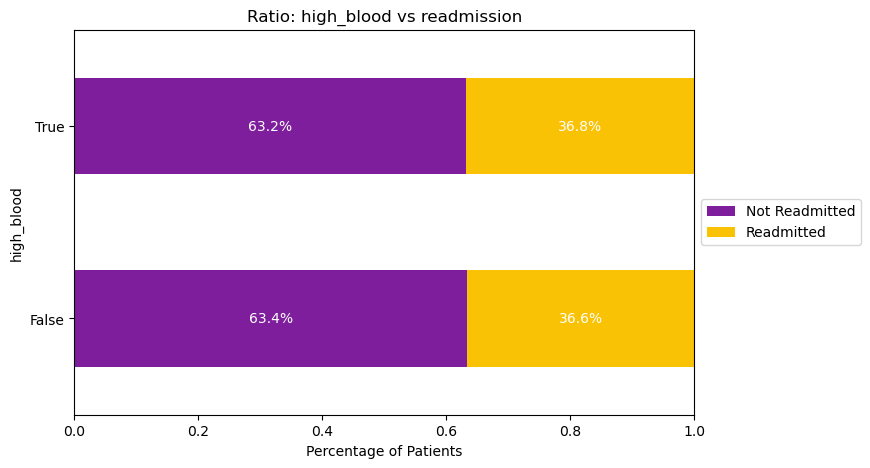

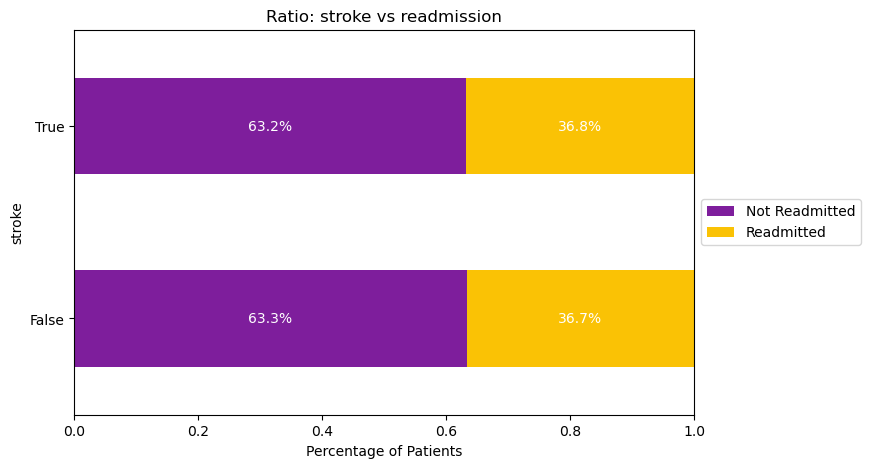

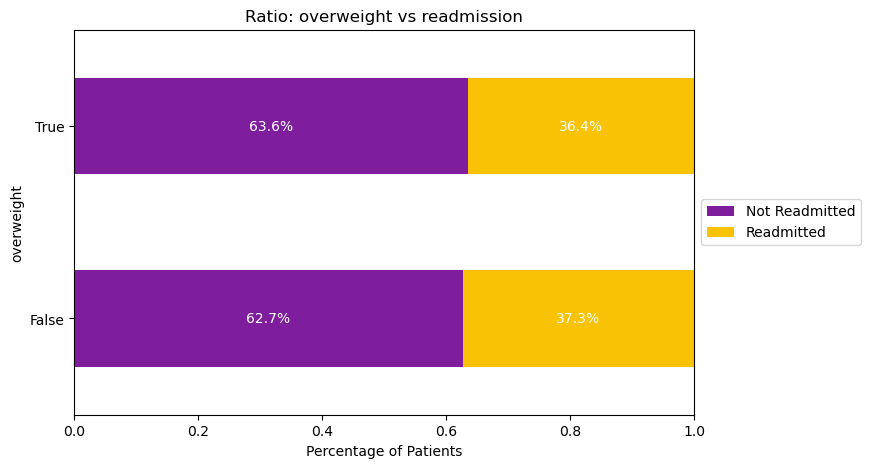

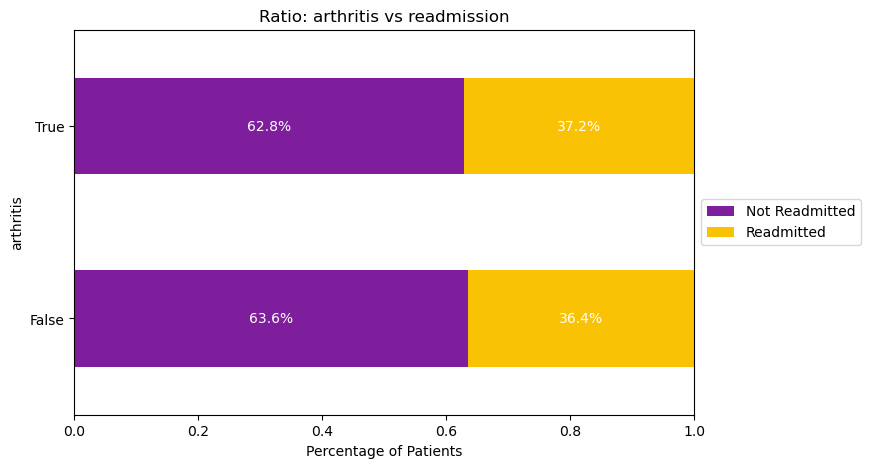

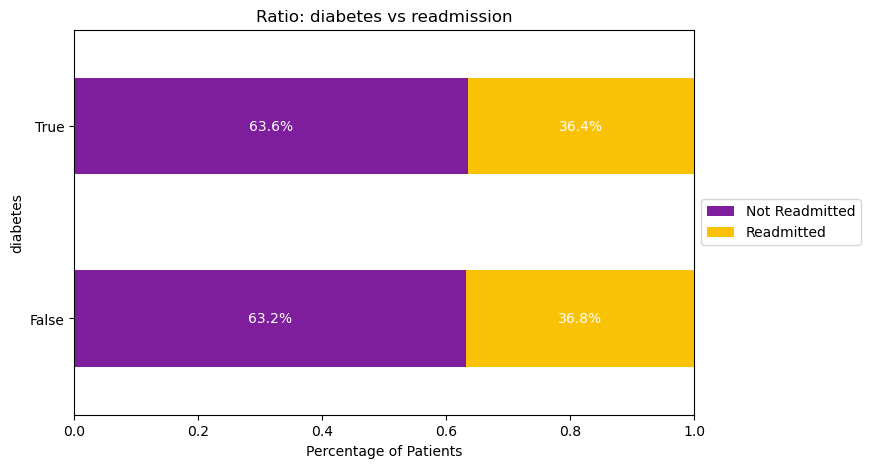

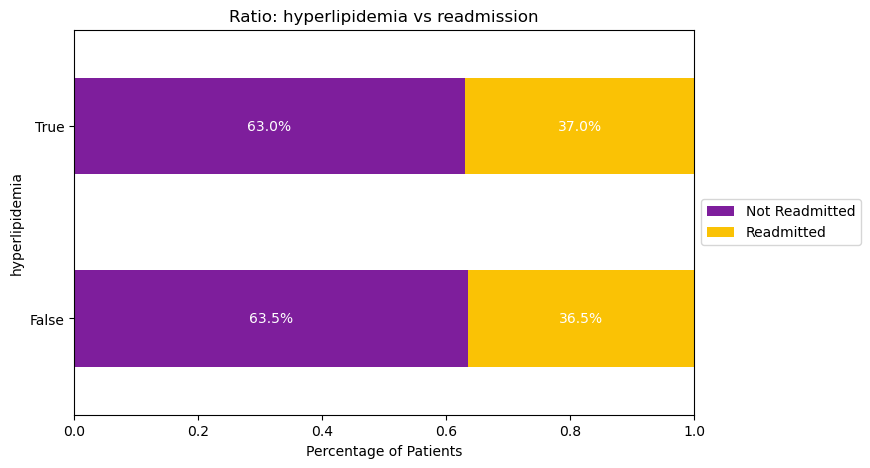

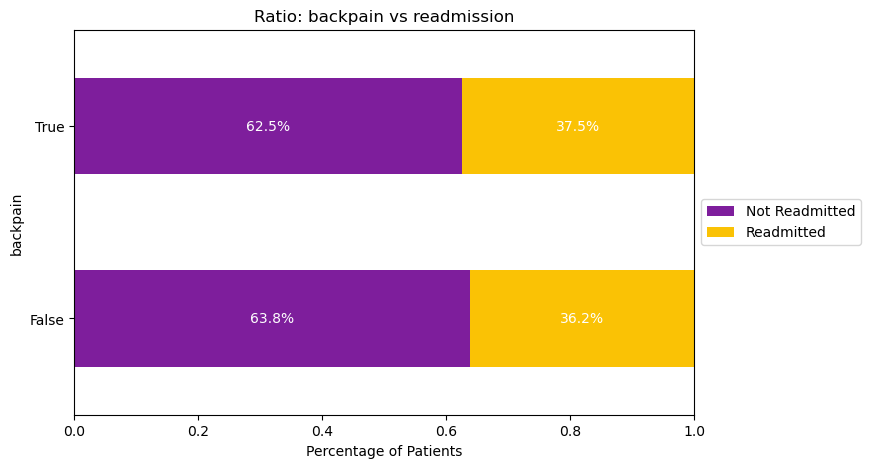

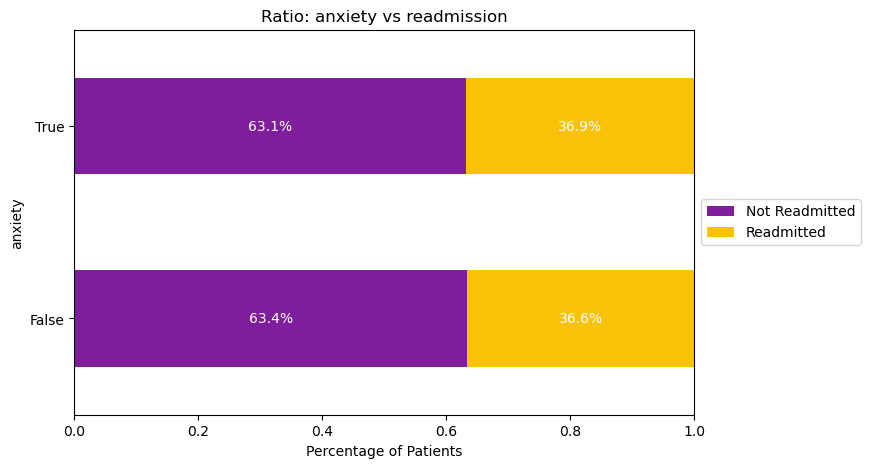

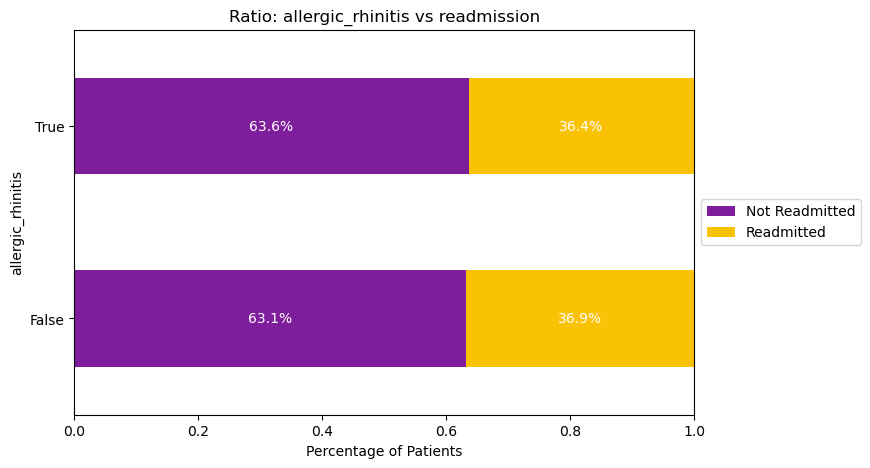

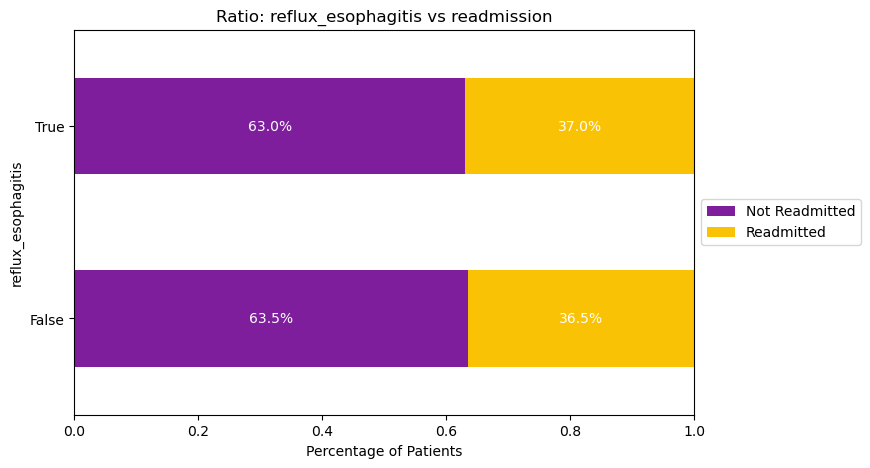

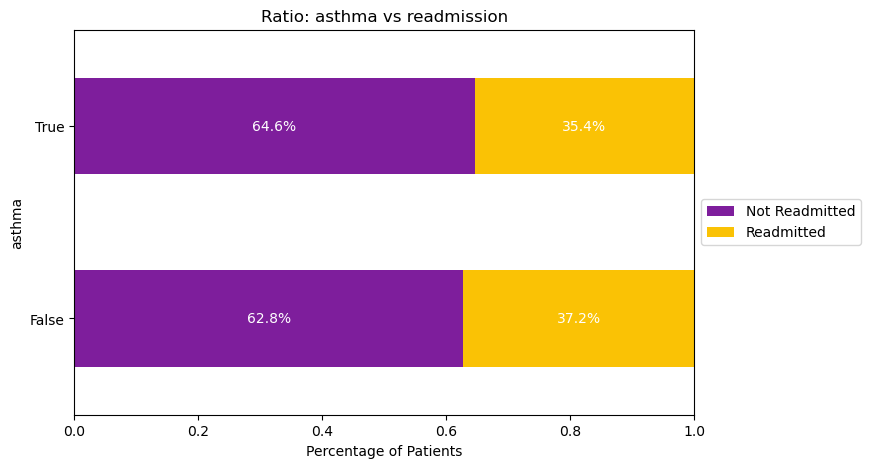

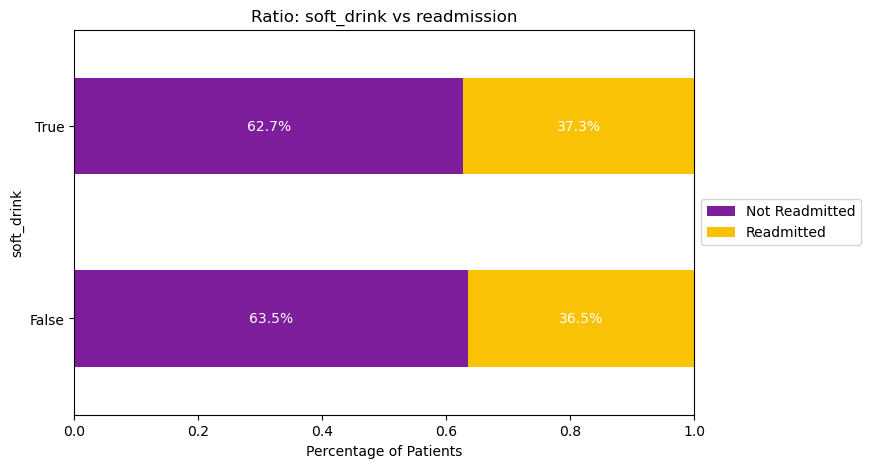

In [16]:
for i in boolean_vars:
    # Create a crosstab and normalize it to get percentages
    crosstab = pd.crosstab(df[i], df['readmission'], normalize='index')
    
    # Rename columns for clarity
    crosstab.columns = ['Not Readmitted', 'Readmitted']
    
    # Plot a percent stacked bar chart
    fig, ax = plt.subplots(figsize=(8, 5))
    crosstab.plot(kind='barh', stacked=True, color=['#7E1E9C', '#FAC205'], ax=ax)
    
    # Add labels and title
    plt.title(f'Ratio: {i} vs readmission')
    plt.xlabel('Percentage of Patients')
    plt.ylabel(i)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim([0, 1])  # Set the x-axis limit to 1 (100%)
    
    # Add percentage labels inside the bars
    for i in range(len(crosstab)):
        for j in range(len(crosstab.columns)):
            ax.text(crosstab.iloc[i].cumsum()[j] - crosstab.iloc[i][j]/2, i, f"{crosstab.iloc[i][j]*100:.1f}%", 
                    color="white", ha="center", va="center")
    
    plt.show()


<Figure size 500x300 with 0 Axes>

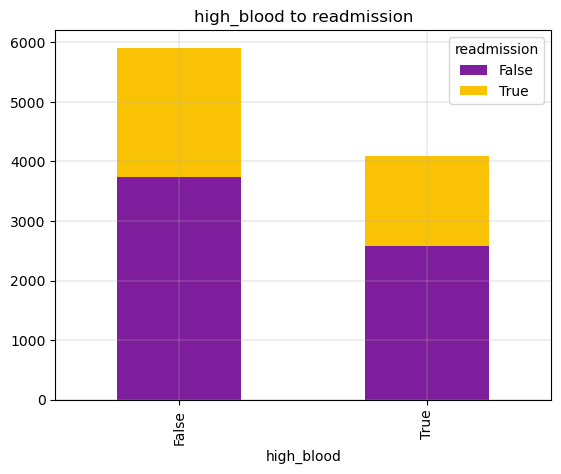

<Figure size 500x300 with 0 Axes>

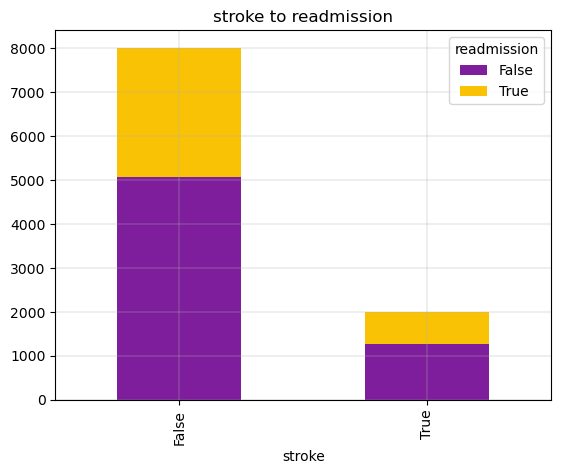

<Figure size 500x300 with 0 Axes>

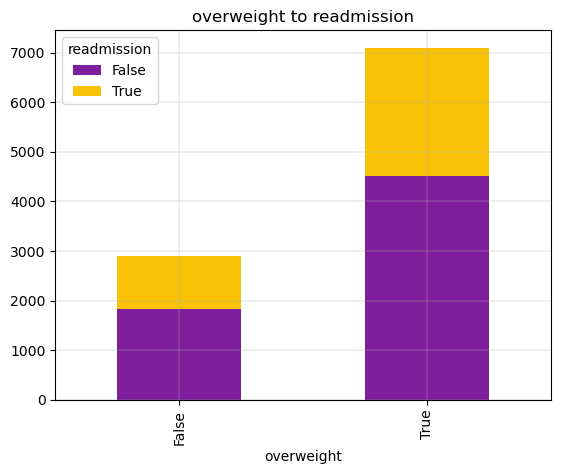

<Figure size 500x300 with 0 Axes>

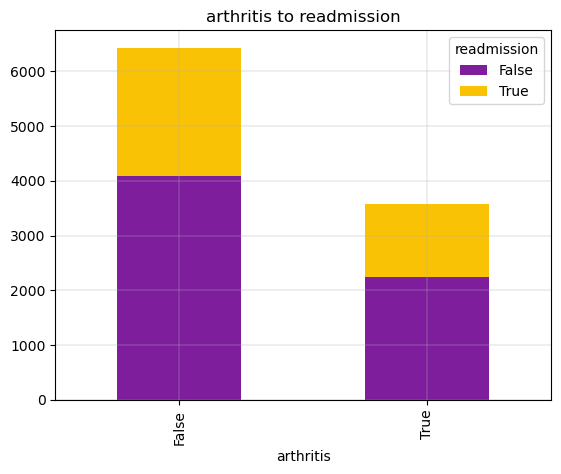

<Figure size 500x300 with 0 Axes>

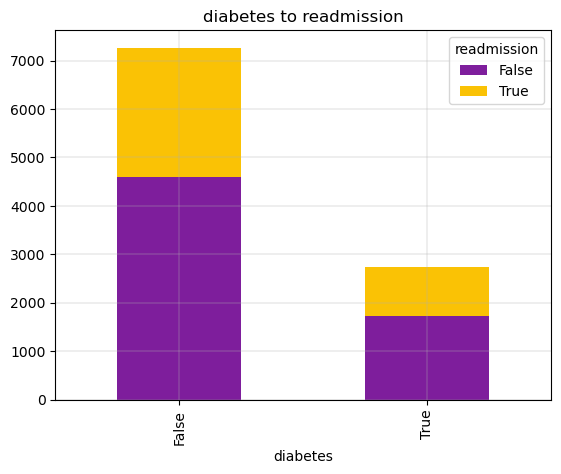

<Figure size 500x300 with 0 Axes>

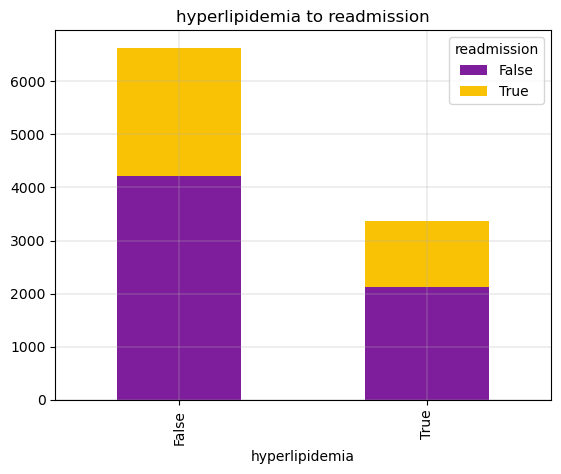

<Figure size 500x300 with 0 Axes>

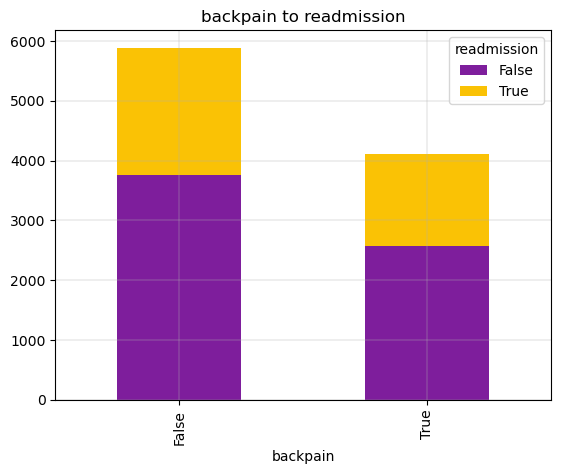

<Figure size 500x300 with 0 Axes>

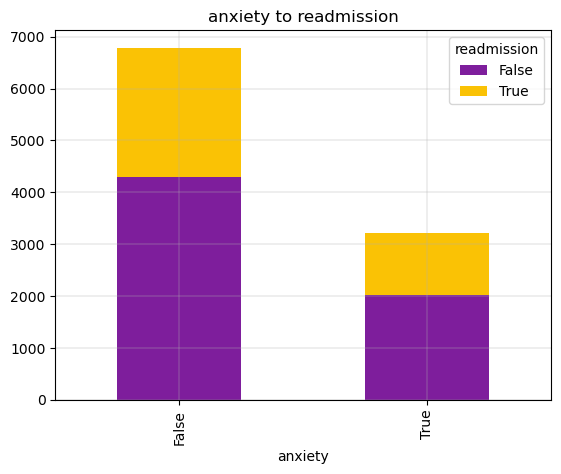

<Figure size 500x300 with 0 Axes>

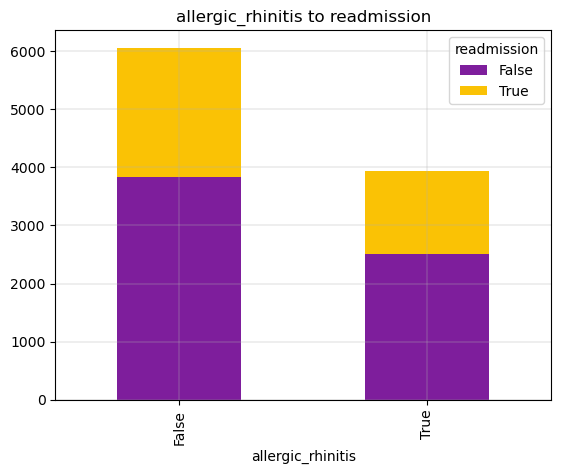

<Figure size 500x300 with 0 Axes>

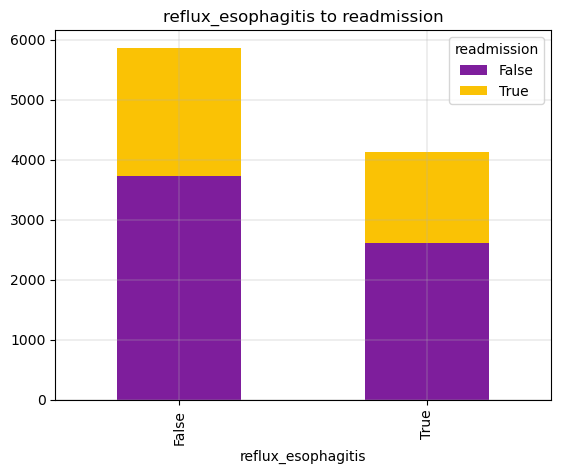

<Figure size 500x300 with 0 Axes>

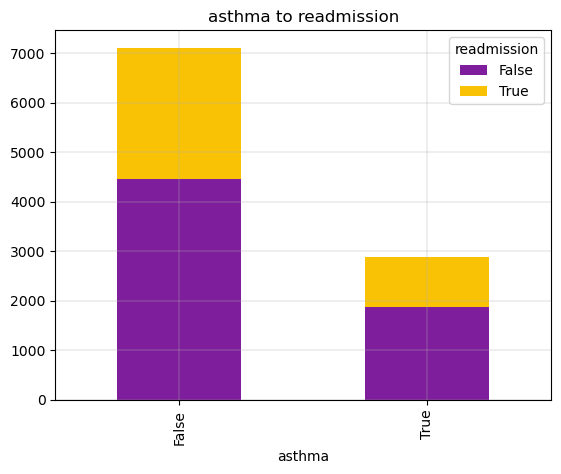

<Figure size 500x300 with 0 Axes>

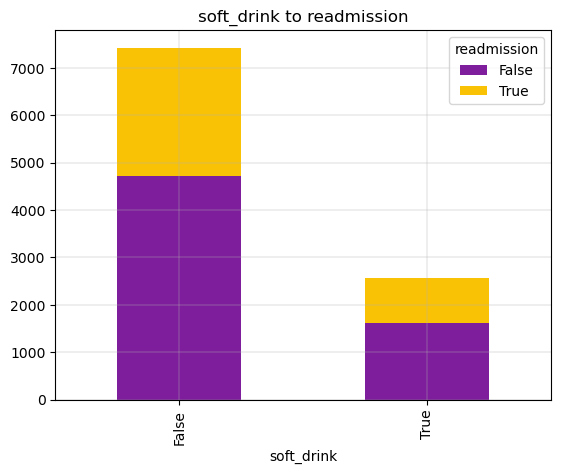

In [17]:
for i in boolean_vars:
    plt.figure(figsize=(5,3))
    # sns.countplot(data=df, x=i, hue='readmission', palette='CMRmap')
    # Create a stacked bar plot
    crosstab = pd.crosstab(df[i], df['readmission'])
    crosstab.plot(kind='bar', stacked=True, color=['#7E1E9C', '#FAC205'])
    plt.title(f'{i} to readmission')
    plt.grid(linewidth=0.3)
    plt.show();

Examining the ratio of readmission among the boolean variables, such as history of stroke and high blood pressure, we observe that the rate of readmissions is similar between patients with and without these conditions. However, the next visualization reveals a slight imbalance in features like stroke and soft drink consumption, which could skew the readmission analysis. While the current data suggests these variables don’t significantly impact the target variable, a more balanced dataset would be necessary to confirm whether the data is truly skewed or if these features could influence readmission rates.

***Quick Scope*** look for multicollinearity

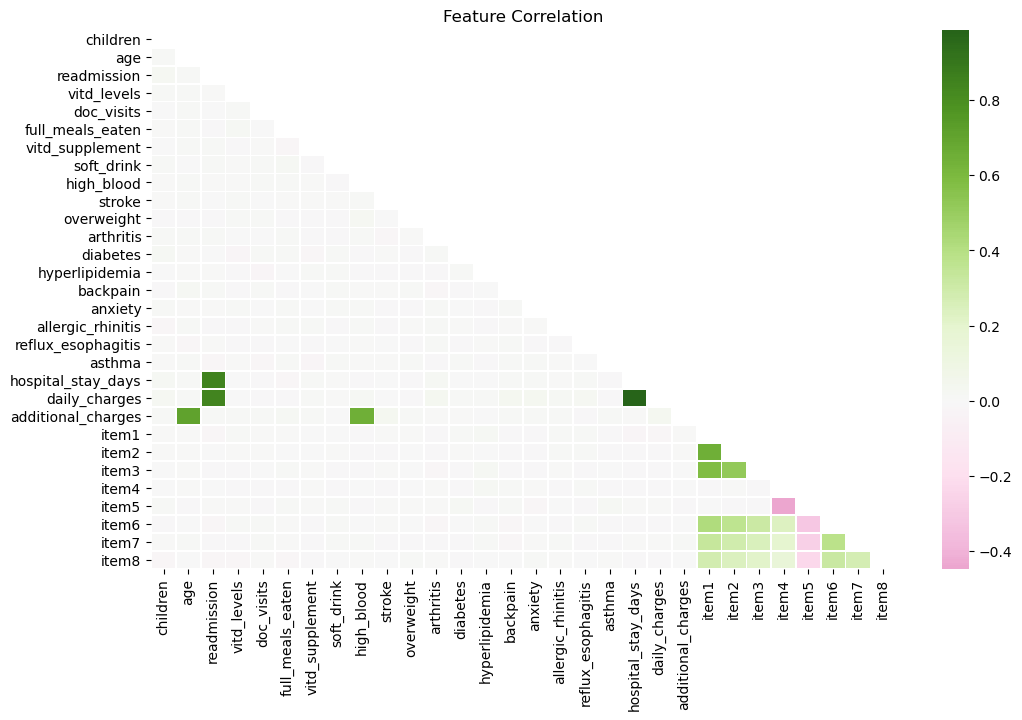

In [18]:
# take a look at a corner heatmap to assess correlation of independent variables
numerical = df.drop(columns=['CaseOrder',
                             'customer_id',
                             'interaction',
                             'unique_id',
                             'city',
                             'state',
                             'county',
                             'zip',
                             'lat',
                             'lng',
                             'population',
                             'income',
                             'job'])
corr = numerical.corr()


plt.figure(figsize=(12,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, linewidths=.5, cmap="PiYG", mask=mask)
plt.title('Feature Correlation')
plt.show()

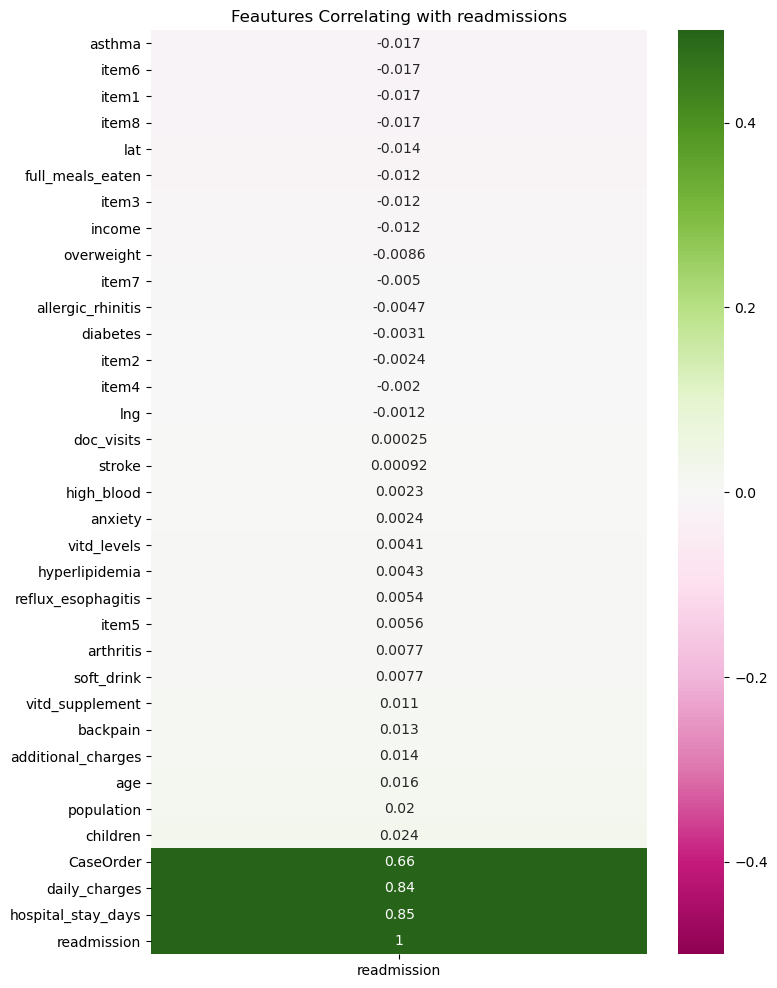

In [19]:
# Take a look at a heatmap of specific correlation to y target
plt.figure(figsize=(8,12))
value_heatmap = sns.heatmap(df.corr()[['readmission']].sort_values(by='readmission',
                                                                   ascending=True),
                            cmap="PiYG", vmin=-.5, vmax=.5, annot=True)
value_heatmap.set_title('Feautures Correlating with readmissions')
plt.show()

## C4.  Data transformation goals

In order to prepare the data for modeling there a few required steps. Algorithms are not built to read text. So to start, all data must be transformed into readable numerical values.

Categorical variables will be engineered into binary dummy columns, representing each unique value within that feature. This process will ensure categorical data is correctly encoded for the model. Columns with Yes/No values will be transformed into 1/0, respectively to simplify their representation as boolean features.

Unique identifiers such as customer_id, interaction and unique_id are removed as they have no relevance to the prediction of stay. Other columns such as those related to location (e.g., city, state, zip) and variables like income and job, will also be omitted in this iteration for ethical considerations and practical analysis constraints. The job feature in particular, contains a large variety of values, making it less efficient to create dummy variables for each category. Instead, methods like clustering or binning could be explored in the future to group jobs meaningfully. Given that this is a minimum viable product (MVP) model, such advanced pre-processing steps can be deferred until necessary or later stages.

From the heatmap above, we observe a strong correlation between daily charges and hospital stay days with readmissions. It is important to consider whether these variables will be available during model deployment and live predictions. If we are predicting readmissions *after* a patient's release, and have access to both the length of stay and average daily charges at that point, then including these features makes sense for predictive modeling. However, if the goal is to predict readmissions *during* the patient's stay, these variables may not be available in real-time, and further clarification would be needed. For now, assuming we have this data post patient discharge, it seems reasonable to include them and proceed with the model.

Lastly, I also chose to remove the feature columns `item1` through `item8`. As expected, these columns have multicollinearity. If a patient answers 8 on one survey question, it is reasonable to assume they would choose the same or within the same range for consequent questions. Additionally, it would be more appropriate to bin them into more generalized categories so as to avoid redundant flag columns and avoid overfitting.

In [20]:
## remove unnecessary columns not used for modeling
remove_cols = ['CaseOrder',
               'customer_id',
               'interaction',
               'unique_id',
               'city',
               'state',
               'county',
               'zip',
               'lat',
               'lng',
               'income',
               'job',
               'timezone'
                ,'item1'
                ,'item2'
                ,'item3'
                ,'item4'
                ,'item5'
                ,'item6'
                ,'item7'
                ,'item8']

filtered_df = df.drop(columns = remove_cols)

#### Nominal Categorical Features

The columns listed below are nominal categorical variables, meaning they represent categories without any inherent order or ranking. For use in a logistic regression model (and for any other), these categorical variables need to be transformed into numerical representations. However, assigning arbitrary numerical values to each category (e.g. 1 for female and 2 for male) would incorrectly imply a meaningful order and mislead the model. To address this, we use dummy variables, which convert each category into a binary (0 or 1) representation, ensuring that no ordinal relationship is inferred between the categories. This process enables the model to correctly interpret the categorical data without the issue of bias.

In [21]:
# dummify nominal
to_dummy = ['gender'
           ,'marital'
           ,'initial_admin'
           ,'services_received'
           ,'complication_risk'
           ,'area']

# Create dummies for the specified columns
dummy_df = pd.get_dummies(filtered_df[to_dummy], drop_first=True)
# Concatenate the original dataframe with the dummies
filtered_df = pd.concat([filtered_df, dummy_df], axis=1)
# # drop the original columns 
filtered_df.drop(columns = to_dummy, inplace=True)

In [22]:
filtered_df.sample(3)

,population,children,age,readmission,vitd_levels,doc_visits,full_meals_eaten,vitd_supplement,soft_drink,high_blood,stroke,overweight,arthritis,diabetes,hyperlipidemia,backpain,anxiety,allergic_rhinitis,reflux_esophagitis,asthma,hospital_stay_days,daily_charges,additional_charges,gender_Male,gender_Nonbinary,marital_Married,marital_Never Married,marital_Separated,marital_Widowed,initial_admin_Emergency Admission,initial_admin_Observation Admission,services_received_CT Scan,services_received_Intravenous,services_received_MRI,complication_risk_Low,complication_risk_Medium,area_Suburban,area_Urban
8097,1591,7,25,False,19.96,5,0,0,True,True,False,True,False,False,True,False,False,True,False,False,49,6557.80,9081.41,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0
7572,906,5,81,True,19.97,3,3,1,True,True,False,False,True,True,False,True,False,False,False,True,71,8072.36,26613.09,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1
6294,5254,1,42,True,20.16,5,1,1,False,True,False,True,True,False,False,False,True,False,True,False,71,8035.05,13845.52,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0


#### Numerical Values
Numerical values are of the correct data type for modeling. There are no unreasonable outliers that need to be addressed. No nulls or duplicated observations were found.

In [23]:
# ensure numerical values are correct dtype
numerical = ['age'
            ,'vitd_levels'
            ,'population'
            ,'children'
            ,'doc_visits'
            ,'full_meals_eaten'
            ,'vitd_supplement']

print(filtered_df[numerical].dtypes)
filtered_df[numerical].describe().T

age                   int32
vitd_levels         float64
population            int32
children              int32
doc_visits            int64
full_meals_eaten      int64
vitd_supplement       int64
dtype: object


,count,mean,std,min,25%,50%,75%,max
age,10000.0,53.511700,20.638538,18.00,36.0000,53.00,71.00,89.00
vitd_levels,10000.0,17.964272,2.017259,9.81,16.6275,17.95,19.35,26.39
population,10000.0,9965.253800,14824.758614,0.00,694.7500,2769.00,13945.00,122814.00
children,10000.0,2.097200,2.163659,0.00,0.0000,1.00,3.00,10.00
doc_visits,10000.0,5.012200,1.045734,1.00,4.0000,5.00,6.00,9.00
full_meals_eaten,10000.0,1.001400,1.008117,0.00,0.0000,1.00,2.00,7.00
vitd_supplement,10000.0,0.398900,0.628505,0.00,0.0000,0.00,1.00,5.00


#### Boolean Value Prep

For modeling preparation, boolean values are handled by converting them to numerical values (1, 0). This conversion allows the model to use these columns as features. For a boolean feature, such as whether a person is *overweight*, the coefficient in the regression model represents the effect of that feature being `True` compared to `False`. Specifically if the boolean is True, the model adds the value of the coefficient to the prediction. However, if False, it does not affect the prediction (e.g. $0$ &nbsp; $x$ &nbsp; $weight = 0)$.

In [24]:
# change boolean to binary
binary = ['high_blood'
         ,'stroke'
         ,'overweight'
         ,'arthritis'
         ,'diabetes'
         ,'hyperlipidemia'
         ,'backpain'
         ,'anxiety'
         ,'allergic_rhinitis'
         ,'reflux_esophagitis'
         ,'asthma'
         ,'soft_drink']

# replace True with 1's and False with 0's
filtered_df[binary] = filtered_df[binary].replace(True, 1)
filtered_df[binary] = filtered_df[binary].replace(False, 0)

In [25]:
# confirm all flag columns
filtered_df[binary].head().T

,0,1,2,3,4
high_blood,1,1,1,0,0
stroke,0,0,0,1,0
overweight,0,1,1,0,0
arthritis,1,0,0,1,0
diabetes,1,0,1,0,0
hyperlipidemia,0,0,0,0,1
backpain,1,0,0,0,0
anxiety,1,0,0,0,0
allergic_rhinitis,1,0,0,0,1
reflux_esophagitis,0,1,0,1,0


## C5.  Provide the prepared data set as a CSV file.

In [26]:
filtered_df.to_csv('logistic_regression_cleaned_df.csv', index=False)
# read back in if needed
filtered_df = pd.read_csv('logistic_regression_cleaned_df.csv')

In [27]:
filtered_df.head(1)

,population,children,age,readmission,vitd_levels,doc_visits,full_meals_eaten,vitd_supplement,soft_drink,high_blood,stroke,overweight,arthritis,diabetes,hyperlipidemia,backpain,anxiety,allergic_rhinitis,reflux_esophagitis,asthma,hospital_stay_days,daily_charges,additional_charges,gender_Male,gender_Nonbinary,marital_Married,marital_Never Married,marital_Separated,marital_Widowed,initial_admin_Emergency Admission,initial_admin_Observation Admission,services_received_CT Scan,services_received_Intravenous,services_received_MRI,complication_risk_Low,complication_risk_Medium,area_Suburban,area_Urban
0,2951,1,53,False,19.14,6,0,0,0,1,0,0,1,1,0,1,1,1,0,1,10,3726.7,17939.4,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0


# Part IV: Model Comparison and Analysis

## D1.  Construct an initial logistic regression model from all independent variables that were identified in part C2.

#### Shuffle/Split
Splitting data for modeling is essential to ensure the model's ability to generalize an algorithm on training data and test true accuracy on unseen data. By dividing the dataset into training, validation and test sets, the model is trained on one portion (the training set) and then evaluated on another portion (the validation set) that it has not seen before. 

The test set is always saved for last and shall only be tested once and only once. This allows for an unbiased assessment of the model's true performance and helps to prevent overfitting, where the model performs well on training data but poorly on new unseen data.

In [28]:
# split data into train, validate and test sets
train_validate, test = train_test_split(filtered_df,
                                        test_size=.2, 
                                        random_state=314,
                                        shuffle=True)

train, validate = train_test_split(train_validate,
                                   test_size=.3, 
                                   random_state=314,
                                   shuffle=True)

print(f'Train shape ---> {train.shape}')
print(f'Validate shape ---> {validate.shape}')
print(f'Test shape ---> {test.shape}')

Train shape ---> (5600, 38)
Validate shape ---> (2400, 38)
Test shape ---> (2000, 38)


In [29]:
# set xtrain and ytrain
X_train_orig = train.drop(columns='readmission')
X_validate_orig = validate.drop(columns='readmission')
X_test_orig = test.drop(columns='readmission')

y_train = train.readmission
y_validate = validate.readmission
y_test = test.readmission

y_train = pd.DataFrame(y_train)
y_validate= pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

#### Kitchen Sink
- Baseline model with all columns

In [30]:
# keep copies of original DF for initial model
X_train_initial = X_train_orig.copy(deep=True)
X_validate_initial = X_validate_orig.copy(deep=True)
X_test_initial = X_test_orig.copy(deep=True)

In [31]:
# adding constant
X_train_sm = sm.add_constant(X_train_initial)

# fit model
logit_model = sm.Logit(y_train.readmission, X_train_sm)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.026116
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                 5600
Model:                          Logit   Df Residuals:                     5562
Method:                           MLE   Df Model:                           37
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                  0.9603
Time:                        21:24:27   Log-Likelihood:                -146.25
converged:                       True   LL-Null:                       -3679.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -168.8648     20.830     -8.107      0.000    -209.690    -128.039
population                           2.845e-06   1.13e-05      0.252      0.801   -1.93e-05     2.5e-05
children                                0.0827      0.077      1.075      0.282      -0.068       0.233
age                                     0.0084      0.024      0.357      0.721      -0.038       0.054
vitd_levels                             0.0472      0.074      0.638      0.523      -0.098       0.192
doc_visits                             -0.0877      0.163     -0.538      0.590      -0.407       0.232
full_meals_eaten                       -0.0070      0.163     -0.043      0.966      -0.327       0.313
vitd_supplement                         0.1377      0.273      0.504      0.614      -0.397       0.673
soft_drink                              0.1370      0.381      0.360      0.719      -0.610       0.884
high_blood                             -2.1121      1.125     -1.877      0.061      -4.318       0.094
stroke                                  1.4653      0.413      3.549      0.000       0.656       2.275
overweight                             -0.4097      0.356     -1.149      0.250      -1.108       0.289
arthritis                              -3.5231      0.662     -5.323      0.000      -4.820      -2.226
diabetes                               -1.8503      0.634     -2.921      0.003      -3.092      -0.609
hyperlipidemia                         -2.8118      0.755     -3.722      0.000      -4.292      -1.331
backpain                               -2.4466      0.667     -3.666      0.000      -3.755      -1.138
anxiety                                -3.2414      0.725     -4.469      0.000      -4.663      -1.820
allergic_rhinitis                      -2.5260      0.529     -4.777      0.000      -3.562      -1.490
reflux_esophagitis                     -2.2555      0.542     -4.160      0.000      -3.318      -1.193
asthma                                 -1.4725      0.364     -4.048      0.000      -2.186      -0.760
hospital_stay_days                     -0.6872      0.554     -1.240      0.215      -1.773       0.399
daily_charges                           0.0305      0.007      4.264      0.000       0.016       0.045
additional_charges                  -3.531e-05   9.75e-05     -0.362      0.717      -0.000       0.000
gender_Male                             0.1834      0.336      0.546      0.585      -0.475       0.842
gender_Nonbinary                       -1.8418      1.095     -1.682      0.093      -3.988       0.304
marital_Married                        -0.0996      0.513     -0.194      0.846      -1.106       0.907
marital_Never Married                  -0.1860      0.545     -0.341      0.733      -1.254       0.882
marital_Separated                      -1.0912      0.580     -1.882      0.060      -2.227       0.045
marital_Widowed  

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train_initial, y_train.readmission)

y_pred = logreg.predict(X_validate_initial)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(logreg.score(X_train_initial, y_train)))
print('Accuracy of logistic regression classifier on validation set: {:.4f}'.format(logreg.score(X_validate_initial, y_validate)))

cfm = confusion_matrix(y_validate, y_pred)

print(cfm)
print('-----')
print(classification_report(y_validate, y_pred))

Accuracy of logistic regression classifier on train set: 0.9416
Accuracy of logistic regression classifier on validation set: 0.9446
[[1450   87]
 [  46  817]]
-----
              precision    recall  f1-score   support

       False       0.97      0.94      0.96      1537
        True       0.90      0.95      0.92       863

    accuracy                           0.94      2400
   macro avg       0.94      0.95      0.94      2400
weighted avg       0.95      0.94      0.94      2400



## D2. Model Reduction Justification

Recursive Feature Elimination (RFE) is a feature selection method from the library sklearn that iteratively removes the least important features from a dataset. Using feature importance, it eliminates the least relevant features, usually repeating this process until the desired number of features is reached.

I chose RFE because it systematically removes less important features to identify a subset that best explains the target variable. The dataset includes many potentially correlated medical and demographic features. This method helps identify which features are most impactful for predicting readmission, aligning with the goal of understanding key contributing factors.

RFE is appropriate for this dataset as it identifies the most relevant features for predicting readmission by removing less important ones, reducing dimensionality and improving model performance while preventing overfitting. This ensures the model focuses on key factors influencing readmission.

In [33]:
# use recursive feature elimination
rfe = RFE(logreg, n_features_to_select=10)

rfe = rfe.fit(X_train_orig, y_train)
top_features = list(X_train_orig.columns[rfe.support_])

# print out of top features
top_features

['high_blood',
 'stroke',
 'arthritis',
 'allergic_rhinitis',
 'hospital_stay_days',
 'gender_Nonbinary',
 'marital_Separated',
 'initial_admin_Emergency Admission',
 'services_received_CT Scan',
 'complication_risk_Low']

The selected features relate to factors influencing patient readmissions by highlighting critical medical conditions (e.g., stroke), hospital factors (e.g., length of stay), and social aspects (e.g., marital status). Correlation of medical history features was hypothesized from the heatmap above and now confirmed through RFE. Nonbinary status is chosen likely due to the imbalance of the feature, and marital status may be anomalous - however it is worth testing their possible association to the target variable. If there is some causality from these personal features, it is worth discovering.

## D3. Reduced Logistic Regression Model

In [34]:
# reassign datasets with top_features from rfe
X_train = X_train_orig[top_features]
X_validate = X_validate_orig[top_features]
X_test = X_test_orig[top_features]

In [35]:
# check via VIF for multicollinearity
vif = pd.DataFrame()
vif['feature'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
vif

,feature,VIF
0,high_blood,1.507392
1,stroke,1.199866
2,arthritis,1.444019
3,allergic_rhinitis,1.508152
4,hospital_stay_days,2.010490
5,gender_Nonbinary,1.017461
6,marital_Separated,1.212799
7,initial_admin_Emergency Admission,1.713765
8,services_received_CT Scan,1.119382
9,complication_risk_Low,1.218452


In [36]:
logreg = LogisticRegression(random_state=123)
logreg.fit(X_train, y_train.readmission)

y_pred = logreg.predict(X_validate)
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on validation set: {:.4f}'.format(logreg.score(X_validate, y_validate)))

cfm = confusion_matrix(y_validate, y_pred)

print(cfm)
print('-----')
print(classification_report(y_validate, y_pred))

Accuracy of logistic regression classifier on train set: 0.9852
Accuracy of logistic regression classifier on validation set: 0.9792
[[1520   17]
 [  33  830]]
-----
              precision    recall  f1-score   support

       False       0.98      0.99      0.98      1537
        True       0.98      0.96      0.97       863

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



In [37]:
# adding constant
X_train_sm = X_train_sm[top_features]
X_train_sm = sm.add_constant(X_train_initial)

# fit model
logit_model = sm.Logit(y_train.readmission, X_train_sm)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.026116
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            readmission   No. Observations:                 5600
Model:                          Logit   Df Residuals:                     5562
Method:                           MLE   Df Model:                           37
Date:                Sat, 05 Oct 2024   Pseudo R-squ.:                  0.9603
Time:                        21:24:28   Log-Likelihood:                -146.25
converged:                       True   LL-Null:                       -3679.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -168.8648     20.830     -8.107      0.000    -209.690    -128.039
population                           2.845e-06   1.13e-05      0.252      0.801   -1.93e-05     2.5e-05
children                                0.0827      0.077      1.075      0.282      -0.068       0.233
age                                     0.0084      0.024      0.357      0.721      -0.038       0.054
vitd_levels                             0.0472      0.074      0.638      0.523      -0.098       0.192
doc_visits                             -0.0877      0.163     -0.538      0.590      -0.407       0.232
full_meals_eaten                       -0.0070      0.163     -0.043      0.966      -0.327       0.313
vitd_supplement                         0.1377      0.273      0.504      0.614      -0.397       0.673
soft_drink                              0.1370      0.381      0.360      0.719      -0.610       0.884
high_blood                             -2.1121      1.125     -1.877      0.061      -4.318       0.094
stroke                                  1.4653      0.413      3.549      0.000       0.656       2.275
overweight                             -0.4097      0.356     -1.149      0.250      -1.108       0.289
arthritis                              -3.5231      0.662     -5.323      0.000      -4.820      -2.226
diabetes                               -1.8503      0.634     -2.921      0.003      -3.092      -0.609
hyperlipidemia                         -2.8118      0.755     -3.722      0.000      -4.292      -1.331
backpain                               -2.4466      0.667     -3.666      0.000      -3.755      -1.138
anxiety                                -3.2414      0.725     -4.469      0.000      -4.663      -1.820
allergic_rhinitis                      -2.5260      0.529     -4.777      0.000      -3.562      -1.490
reflux_esophagitis                     -2.2555      0.542     -4.160      0.000      -3.318      -1.193
asthma                                 -1.4725      0.364     -4.048      0.000      -2.186      -0.760
hospital_stay_days                     -0.6872      0.554     -1.240      0.215      -1.773       0.399
daily_charges                           0.0305      0.007      4.264      0.000       0.016       0.045
additional_charges                  -3.531e-05   9.75e-05     -0.362      0.717      -0.000       0.000
gender_Male                             0.1834      0.336      0.546      0.585      -0.475       0.842
gender_Nonbinary                       -1.8418      1.095     -1.682      0.093      -3.988       0.304
marital_Married                        -0.0996      0.513     -0.194      0.846      -1.106       0.907
marital_Never Married                  -0.1860      0.545     -0.341      0.733      -1.254       0.882
marital_Separated                      -1.0912      0.580     -1.882      0.060      -2.227       0.045
marital_Widowed  

## E1.  Compare: Initial Logistic Regression Model v. Reduced Logistic Regression Model.

- The initial model's pseudo R-squared of 0.96 indicates an exceptionally high goodness of fit. Such a high score is unusual in real world scenarios and may raise concerns about overfitting. However, in the case of a simple school project with clean and tidy data, this score could be reasonable. It suggests that the model explains a significant amount of the variance in the target variable.

- For the initial model, the features with significant relevance include medically relevant characteristics such as whether the patient has had stroke, diabetes, hyperlipidemia back pain anxiety allergic rhinitis reflux esophagitis and asthma as well as whether the admission was an emergency Receiving services like a CT scan or MRI also significantly impacts the likelihood of readmission. Interestingly, complication risk levels (low and medium) are also relevant, which seems counterintuitive and may need further exploration.

- For the reduced model, I applied recursive feature elimination instead of relying solely on features with low p-values. The selected features differed significantly from the initial model, including hospital stay length non-binary gender and marital separation The heatmap confirms a strong correlation between hospital length of stay and readmissions.

- Surprisingly, the reduced model outperformed the initial model across all metrics, including accuracy and F1-score The recall improved slightly by 0.1%, which I consider the most important metric in this context. Recall focuses on minimizing false negatives (patients predicted not to be readmitted but who are), which is critical in healthcare. It is essential to monitor that recall remains the same or improves during model tuning, as metrics like F1-score and accuracy can be misleading if the model has a high true positive count.

## E2.  Model Results & Calculations

### Initial Base Model

In [38]:
# assign a variable to my model
logit1 = LogisticRegression(random_state=123)

print('Initial Model: ', logit1)
print('----------')

# fit my model
logit1.fit(X_train_orig, y_train)

# assign variable to prediction array
y_pred = logit1.predict(X_train_orig)

# assign variables to my confusion matrix output
tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
print("True Positives", tp)
print("False Positives", fp)
print("False Negatives", fn)
print("True Negatives", tn)

print("-------------")

accuracy = round((tp + tn) / (tp + tn + fp + fn), 3)
recall = round(tp / (tp + fn), 3)
precision = round(tp / (tp + fp), 3)

print("Accuracy is", accuracy)
print("Recall is", recall)
print("Precision is", precision)

print("-------------")

# set up and print my classification report
print(classification_report(y_train, y_pred))

print("-------------")


print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train_orig, y_train)))
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit1.score(X_validate_orig, y_validate)))

Initial Model:  LogisticRegression(random_state=123)
----------
True Positives 1930
False Positives 205
False Negatives 122
True Negatives 3343
-------------
Accuracy is 0.942
Recall is 0.941
Precision is 0.904
-------------
              precision    recall  f1-score   support

       False       0.96      0.94      0.95      3548
        True       0.90      0.94      0.92      2052

    accuracy                           0.94      5600
   macro avg       0.93      0.94      0.94      5600
weighted avg       0.94      0.94      0.94      5600

-------------
Accuracy of Logistic Regression classifier on training set: 0.94
Accuracy of Logistic Regression classifier on validate set: 0.94


In [39]:
# assign a variable to my model
logit_reduced = LogisticRegression(random_state=123)

print('Reduced Model: ', logit_reduced)
print('----------')

# fit my model
log_red = logit_reduced.fit(X_train, y_train)

# assign variable to prediction array
y_pred2 = logit_reduced.predict(X_train)

# assign variables to my confusion matrix output
tn, fp, fn, tp = confusion_matrix(y_train, y_pred2).ravel()
print("True Positives", tp)
print("False Positives", fp)
print("False Negatives", fn)
print("True Negatives", tn)

print("-------------")

accuracy = round((tp + tn) / (tp + tn + fp + fn),3)
recall = round(tp / (tp + fn),3)
precision = round(tp / (tp + fp),3)

print("Accuracy is", accuracy)
print("Recall is", recall)
print("Precision is", precision)

print("-------------")

# set up and print my classification report
print(classification_report(y_train, y_pred2))

print("-------------")


print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit_reduced.score(X_train, y_train)))
print('Accuracy of Logistic Regression classifier on validate set: {:.2f}'
     .format(logit_reduced.score(X_validate, y_validate)))

Reduced Model:  LogisticRegression(random_state=123)
----------
True Positives 2012
False Positives 43
False Negatives 40
True Negatives 3505
-------------
Accuracy is 0.985
Recall is 0.981
Precision is 0.979
-------------
              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3548
        True       0.98      0.98      0.98      2052

    accuracy                           0.99      5600
   macro avg       0.98      0.98      0.98      5600
weighted avg       0.99      0.99      0.99      5600

-------------
Accuracy of Logistic Regression classifier on training set: 0.99
Accuracy of Logistic Regression classifier on validate set: 0.98


# Part V: Data Summary and Implications

## F1.  Results of Data Analysis

In [40]:
coeff = log_red.coef_[0]
intercept = log_red.intercept_[0]

# coefficients
for feature, coef in zip(X_train.columns, coeff):
    print(f"Feature: {feature}, : {coef:.2f}")

print(f"Intercept: {intercept}")

Feature: high_blood, : 0.65
Feature: stroke, : 1.20
Feature: arthritis, : -0.97
Feature: allergic_rhinitis, : -0.55
Feature: hospital_stay_days, : 1.32
Feature: gender_Nonbinary, : -0.68
Feature: marital_Separated, : -0.48
Feature: initial_admin_Emergency Admission, : 1.86
Feature: services_received_CT Scan, : 0.99
Feature: complication_risk_Low, : -1.28
Intercept: -71.93553149117237


**Regression Equation**
\
$\log\left(\frac{p}{1-p}\right) = 0.65 \cdot \text{high\_blood} + 1.20 \cdot \text{stroke} - 0.97 \cdot \text{arthritis} - 0.55 \cdot \text{allergic\_rhinitis} + 1.32 \cdot \text{hospital\_stay\_days}$
\
\
$- 0.68 \cdot \text{gender\_Nonbinary} - 0.48 \cdot \text{marital\_Separated} + 1.86 \cdot \text{initial\_admin\_Emergency\_Admission} + 0.99 \cdot \text{services\_received\_CT\_Scan} - 1.28 \cdot \text{complication\_risk\_Low} - 71.94
$




**Interpretation of Coefficients**
The model reveals several factors that influence the likelihood of patient readmission. Conditions such high blood pressure (0.65) and a history of stroke (1.20) increase the chances of readmission, with stroke being one of the most influential factors. In contrast, patients with arthritis (-0.97) and allergic rhinitis (-0.55) are less likely to be readmitted. 

Longer hospital stays (1.32) and emergency admissions (1.86) have very strong correlations to the target variable and significantly raise the probability of readmission. Trailing behind, receiving a CT scan (0.99) also points to a higher likelihood of being readmitted within 30 days of release. 

Strangely enough, Nonbinary gender (-0.68) and marital separation (-0.48) appear to lower the odds of being readmitted. Patients with low complication risk (-1.28) are less likely to return to the hospital. The low intercept of -71.94 indicates a baseline probability of readmission without considering these factors. Overall, medical history, admission type, and hospital stay duration are key predictors of readmission in this model.

**Statistical versus Practical Significance**
In the end, the strongest positive predictors of the target variable were medical history, emergency admission type, length of hospital stay, and interestingly, being of nonbinary gender or in a separated marital status. The p-values initially suggested that medical history would play a strong role. This was confirmed by the significant impact of conditions like stroke and high blood pressure on readmission rates. The admission type had both negative and positive effects on readmission, which makes sense in real world scenarios; emergency admissions can be expected to result in increased likelihood of readmission. Similarly, the association between receiving a CT scan and higher readmission odds also aligns with the severity of the medical visit likely requiring higher level scans.

However, the influence of nonbinary gender and separated marital status is less straightforward. The anomalous effect of nonbinary gender is likely due to the underrepresentation of this group in the dataset, leading to a statistically significant but not practically meaningful result. As for marital status, while being separated was equally represented in the dataset, the positive impact on readmission may warrant a deeper dive into this spurrious correlation. It is possible that this could suggest emotional factors playing a role in a patient's recovery process and thus affecting readmission likelihood.

**Limitations of Analysis**
The imbalance in the dataset is a limitation. Additional data is both valuable and necessary. A larger, more balanced dataset would allow to more accurately distinguish between features that are true causal factors for readmission and those that are statistically significant but lack practical relevance. This would improve the model’s reliability and ensure it captures legitimate and meaningful patterns in the data. Further on imbalance, feature represenation like non binary gender are under represented in this dataset. This led to a likely anomalous relation with readmission rates.

Emergency admissions were identified as a strong predictor, which is expected. However, the model could be overly reliant on this feature, overshadowing other important but more subtle predictors. An idea I would explore further is a model ensemble, one for each type of admission or at least separating emergency admissions into a separate model to help hone in on those subtle feature relationships.

## F2.  Recommendations.

Based on the model results, my key recommendations include providing more personal follow up care for patients with serious medical conditions like stroke and high blood pressure, as they are at higher risk of readmission. Adding in more follow up care after discharge such as scheduled check-ins may help reduce their chance of readmission.

Emergency admissions also predict higher readmission rates so, improving discharge planning for patients admitted under this status is crucial. Additionally, closer monitoring of patients who receive CT scans might reduce readmissions.

As mentioned above, more data would be vital to model maintenance and improvements. Identifying which features have a legitimate linear relationship with the target variable as well as a balanced dataset will help further identify areas needed for improvement in hospital care overall.

# H. Sources
1. [Spiceworks. *What is Logistic Regression?*](https://www.spiceworks.com/tech/artificial-intelligence/articles/what-is-logistic-regression/)

3. [GeeksforGeeks. *Understanding Logistic Regression.*](https://www.geeksforgeeks.org/understanding-logistic-regression/)

4. [DeepML1818. *Python Statistical Modeling: Linear and Logistic Regression with Statsmodels.* Medium.](https://medium.com/@deepml1818/python-statistical-modeling-linear-and-logistic-regression-with-statsmodels-124b3da9c30c)

5. [The Stats Geek. *R-squared in Logistic Regression.*](https://thestatsgeek.com/2014/02/08/r-squared-in-logistic-regression/)

6. [Da Data Guy. *Logistic Regression Using Statsmodels.* Medium.](https://dadataguy.medium.com/logistic-regression-using-statsmodels-a63e7944de76)

7. [IBM. *Confusion Matrix.*](https://www.ibm.com/topics/confusion-matrix)